<a href="https://colab.research.google.com/github/dadkins20/machine-learning/blob/master/dcgan-working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ensure Tensorflow 2.0

# !pip install --upgrade pip 
# !pip install --upgrade tensorflow
# !pip install --upgrade tensorflow-gpu

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16702270169085358951, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16025664950867531732
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5330377128502860473
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18241557178743867591
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [2]:
import tensorflow as tf

from tensorflow.python.keras import backend as K
from keras.datasets import cifar10

import matplotlib.pyplot as plt
import numpy as np
import time
import os
import datetime
import imageio

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# for i in range(len(physical_devices)):
#     tf.config.experimental.set_memory_growth(physical_devices[i], True)

# tensorboard doesn't work in AWS Sagemaker
# from packaging import version
# %load_ext tensorboard

# logs_base_dir = "./logs"
# os.makedirs(logs_base_dir, exist_ok=True)
# %tensorboard --logdir {logs_base_dir}

# logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# file_writer = tf.summary.create_file_writer(logdir)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Using TensorFlow backend.


In [3]:
(train_images, _), (_,_) = cifar10.load_data()

def get_real_data(X, batch_size):
    randoms = np.random.randint(0,X.shape[0], batch_size)
    real_images = train_images[randoms]
    real_images = (real_images - 127.5) / 127.5
    return np.array(real_images)
  
X = get_real_data(X=train_images,batch_size=64)
X.shape, X.min(), X.max()

170500096/170498071 [==============================] - 6s 0us/step


((64, 32, 32, 3), -1.0, 1.0)

In [4]:
def get_generator_model():
    
    # use kernel=4,4 ; stride=2,2 per piazza post
    # use softmax as activation per Project 1 description from class
    # use BatchNormalization per Project 1 description from class
    # use relu per https://arxiv.org/pdf/1511.06434.pdf
    # use 0.5 dropout per https://arxiv.org/pdf/1511.06434.pdf
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Input(shape=(100,)))

    model.add(tf.keras.layers.Dense(4*4*128, activation='relu'))
    model.add(tf.keras.layers.Reshape((4,4,128)))
    model.add(tf.keras.layers.BatchNormalization())

    #make 8x8x128
    model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())

    #make 16x16x64
    model.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(4,4), strides=(2,2), padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())

    #make 32x32x32
    model.add(tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(4,4), strides=(2,2), padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())

    #make 32x32x3
    model.add(tf.keras.layers.Conv2D(filters=3, kernel_size=(1,1), strides=(1,1), activation='tanh', padding='same'))
    
#     generator_optimizer = tf.keras.optimizers.Adam(lr=0.00015, beta_1=0.5)
#     model.compile(loss='binary_crossentropy', optimizer=generator_optimizer, metrics=['accuracy'])

    model.summary()

    return model
  
generator = get_generator_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              206848    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         262272    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 64)        131136    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        2

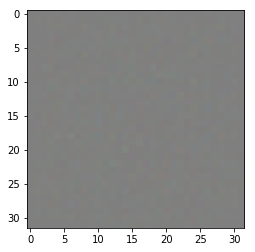

In [5]:
def generate_noise(n):
    noise = tf.random.normal([n, 100])
    noise = tf.reshape(noise, [n, 100])  
    return noise


#make sure we create the right size image
noise = generate_noise(1)
generated_image = generator.predict(noise)
# Normalize images
generated_image = 0.5 * generated_image + 0.5
plt.imshow(generated_image[0], cmap="gist_rainbow")

In [6]:
def get_discriminator_model():
    
    # use LeakyReLU per https://arxiv.org/pdf/1511.06434.pdf
    # use Dropout 0.5 per https://arxiv.org/pdf/1511.06434.pdf
    # use BatchNormalization per Project 1 class description
    # use softmax as final activation layer per Project 1 class description
    # use AdamOptimizer.  I've tried different learning rates but nothing really works.
    # user kernel = 3,3 and strides 1,1 per piazza post
    
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', input_shape=(32,32,3)))
    model.add(tf.keras.layers.LeakyReLU(0.2))

#     model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.LeakyReLU(0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same'))
#     model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.2))

    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.LeakyReLU(0.2))
    
#    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same'))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  
    
    model.summary()
    
    discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer, metrics=['accuracy'])

    return model
  
discriminator = get_discriminator_model()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [7]:
def get_gan_model(gm, dm):
    
    # per Mohammed office hours
    
    z = tf.keras.Input(shape=(100,))
    img = gm(z)
    
    dm.trainable = False
    
    valid = dm(img)
    
    model = tf.keras.Model(z, valid)
    gan_optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=gan_optimizer, metrics=['accuracy'])
    model.summary()

    return model

gan = get_gan_model(generator, discriminator)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         634563    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 632961    
Total params: 1,267,524
Trainable params: 633,859
Non-trainable params: 633,665
_________________________________________________________________


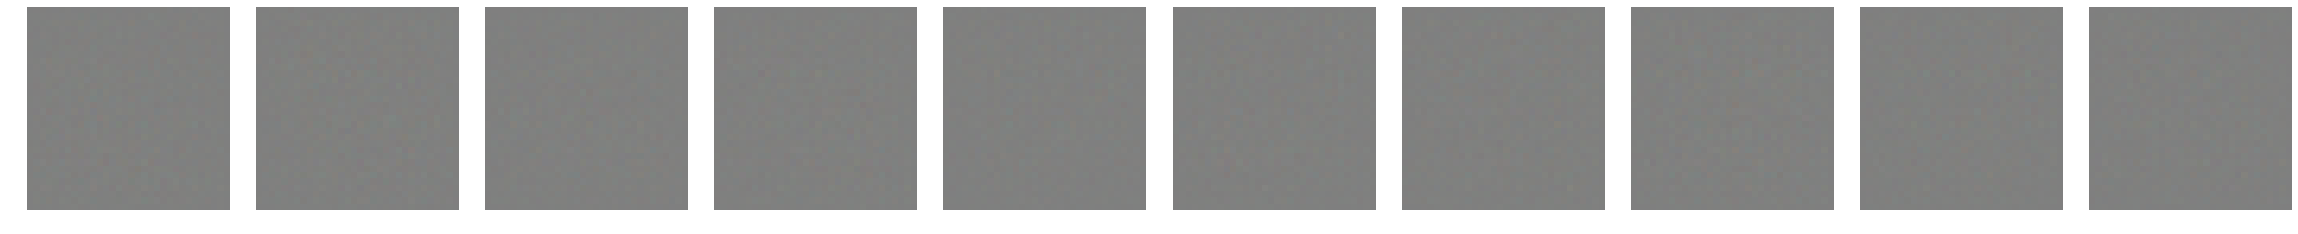

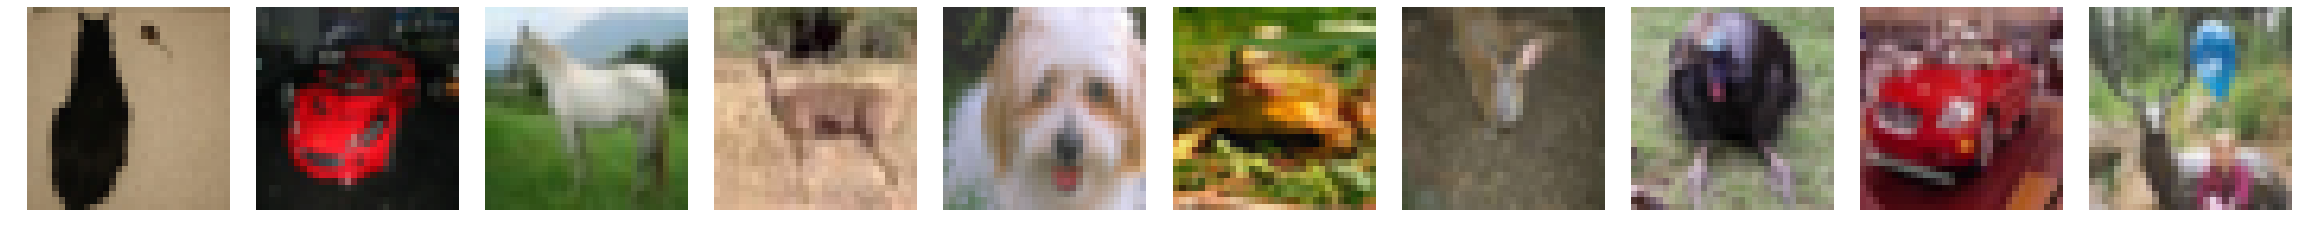

In [8]:
#Display output
def show_images(t, n):
    if t == 'real':
        imgs = get_real_data(train_images,n)
    else:
        imgs = generator.predict(generate_noise(n), steps=1)
        
    # Normalize images
    imgs = (0.5 * imgs) + 0.5
    
    plt.figure(figsize=(32,32))
    #   print(preds[0])
    for i in range(imgs.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()
    plt.show()

show_images('fake', 10)
show_images('real', 10)

In [0]:
def train(epochs,batch_size): # first is epochs, second is batch size
    
    # these are our labels.  We don't want to use 1 and 0 explicitly to help slow training
    real_labels = np.ones(batch_size)
    fake_labels = np.zeros(batch_size)
    fuzzy_real_labels = real_labels - (np.random.random_sample(batch_size)*0.05)
    fuzzy_fake_labels = np.random.random_sample(batch_size)*0.05
    
    print(f"Starting Epoch (0,{epochs})")

    for epoch in range(epochs):
    
        start = time.time()
        
        # get real images
        real_images = get_real_data(train_images,batch_size)
        
        # generate images
        noise = generate_noise(batch_size)
        fake_images = generator(noise)
        
        # train discriminator
        discriminator.trainable = True
        d1_loss, d1_acc = discriminator.train_on_batch(real_images, fuzzy_real_labels)
        d2_loss, d2_acc = discriminator.train_on_batch(fake_images, fuzzy_fake_labels)
        
        d_loss = (d1_loss + d2_loss)/2
        d_acc = (d1_acc + d2_acc)/2
        
        # print("D1Loss:",d1_loss, "D2Loss:",d2_loss, "D1Acc:",d1_acc, "D2Acc:",d2_acc)
        
        # train gan to think fake images are real
        more_fake_noise = generate_noise(batch_size)
        discriminator.trainable = False
        g_loss, g_acc = gan.train_on_batch(more_fake_noise, fuzzy_real_labels)
        
        if epoch % 100 == 0:
            show_images('fake', 10)
            show_images('real', 10)
      
#         with file_writer.as_default():
#             tf.summary.scalar(name="discriminator_accuracy", data=discriminator_metrics[0], step=i)
#             tf.summary.scalar(name="gan_accuracy", data=gan_metrics[0], step=i)
#             tf.summary.scalar(name="FID", data=get_fid(real_images,fake_images))
#             image = generator.predict(generate_noise(1), batch_size=batch_size)
#             image = np.reshape(image, (-1,32,32,3))
#             tf.summary.image("Training data", image, step=(i,j))

#         print(discriminator.metrics_names)
#         print(gan.metrics_names)
        print(f"Starting Epoch ({epoch+1},{epochs}), Time is {round(time.time() - start,2)}, DLoss: {d_loss}, DAcc:{d_acc}, GLoss: {g_loss}, GAcc:{g_acc}")


Starting Epoch (0,100000)


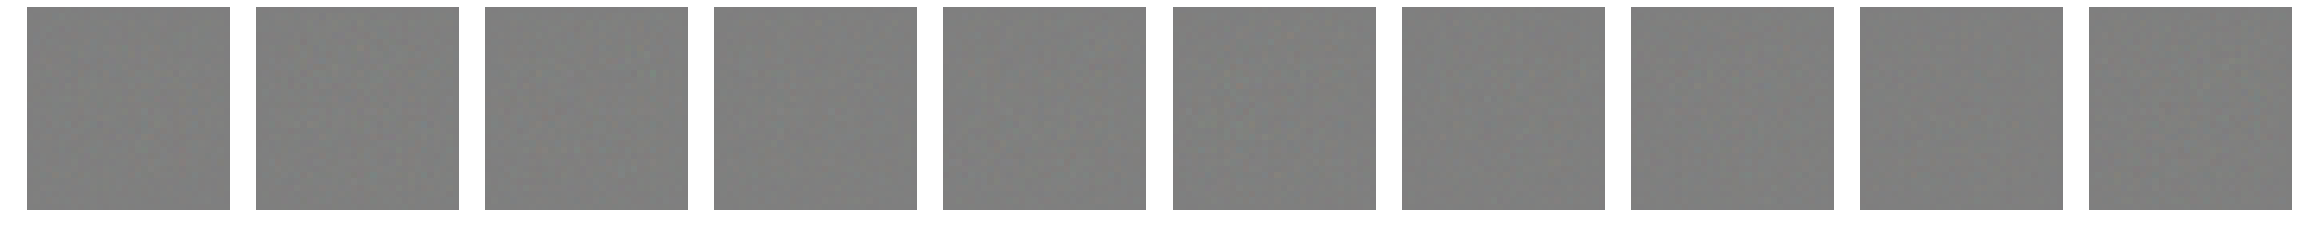

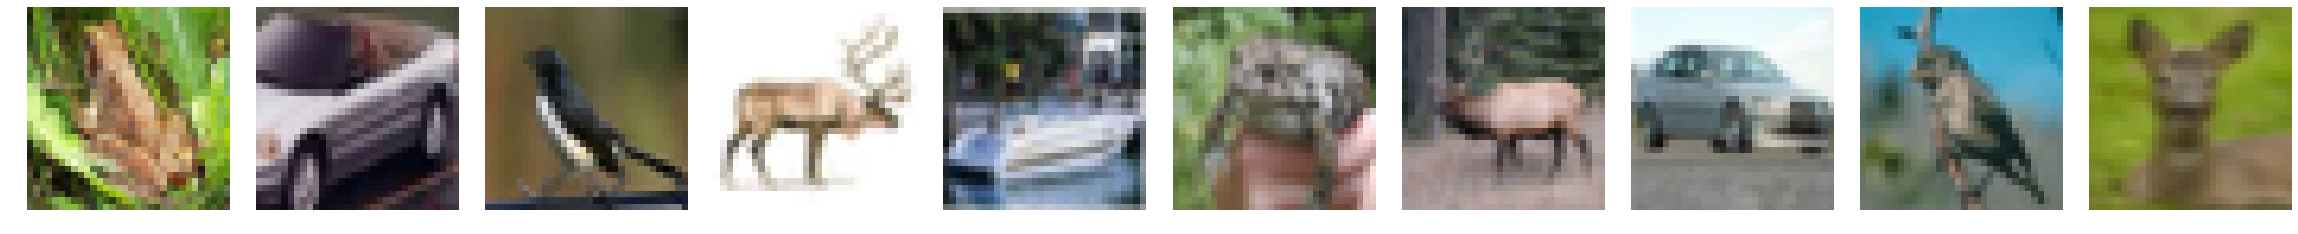

Starting Epoch (1,100000), Time is 5.41, DLoss: 0.6840606927871704, DAcc:0.0, GLoss: 0.2888810336589813, GAcc:0.0
Starting Epoch (2,100000), Time is 0.54, DLoss: 0.5230321884155273, DAcc:0.0, GLoss: 0.1405939906835556, GAcc:0.0
Starting Epoch (3,100000), Time is 0.44, DLoss: 0.4514288902282715, DAcc:0.0, GLoss: 0.11190064251422882, GAcc:0.0
Starting Epoch (4,100000), Time is 0.43, DLoss: 0.4247009754180908, DAcc:0.0, GLoss: 0.12744784355163574, GAcc:0.0
Starting Epoch (5,100000), Time is 0.44, DLoss: 0.4201238453388214, DAcc:0.0, GLoss: 0.14952407777309418, GAcc:0.0
Starting Epoch (6,100000), Time is 0.43, DLoss: 0.419775128364563, DAcc:0.0, GLoss: 0.1624974012374878, GAcc:0.0
Starting Epoch (7,100000), Time is 0.43, DLoss: 0.4182059168815613, DAcc:0.0, GLoss: 0.16585244238376617, GAcc:0.0
Starting Epoch (8,100000), Time is 0.43, DLoss: 0.412376344203949, DAcc:0.0, GLoss: 0.16036558151245117, GAcc:0.0
Starting Epoch (9,100000), Time is 0.43, DLoss: 0.398772656917572, DAcc:0.0, GLoss: 0

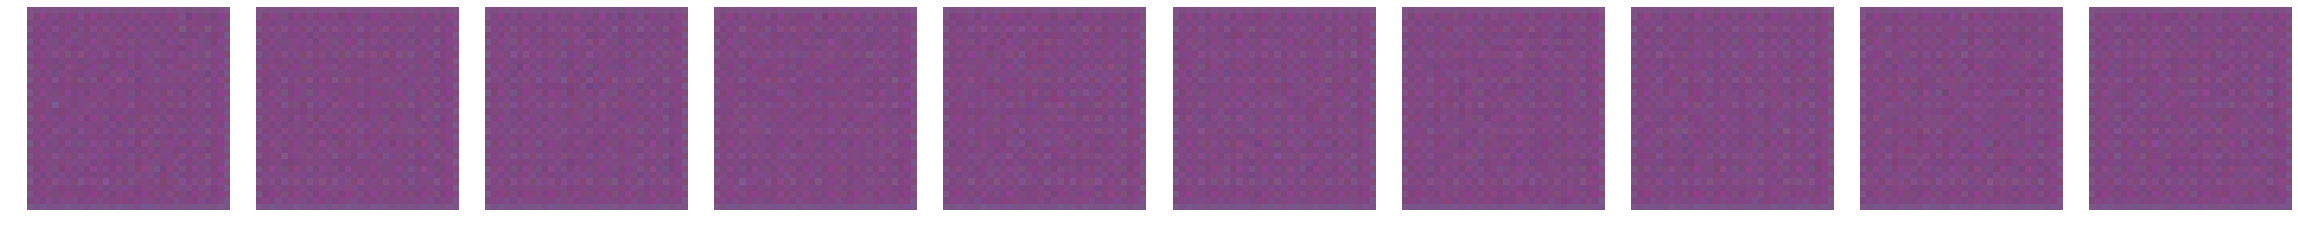

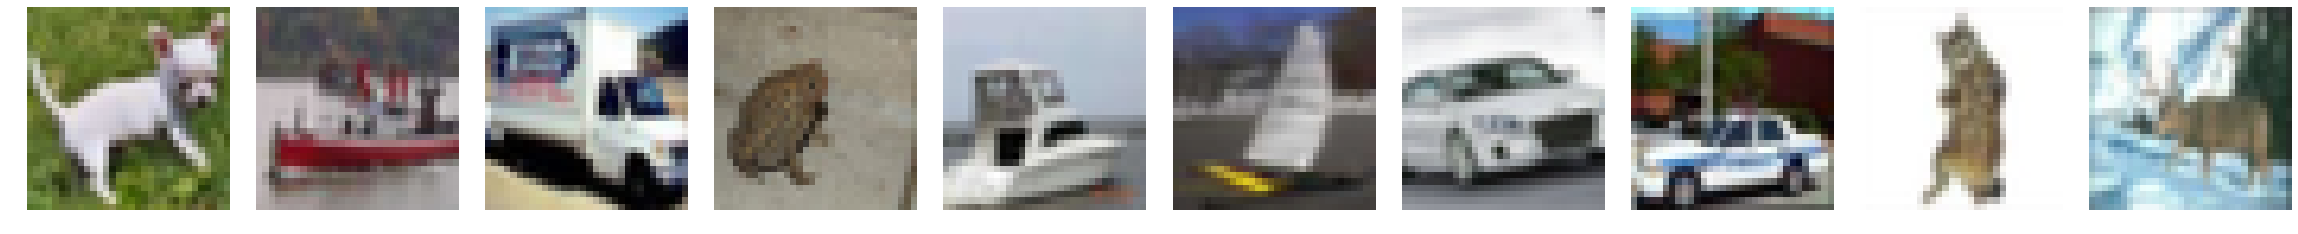

Starting Epoch (101,100000), Time is 3.97, DLoss: 0.11965800821781158, DAcc:0.0, GLoss: 0.11816191673278809, GAcc:0.0
Starting Epoch (102,100000), Time is 0.54, DLoss: 0.11763139069080353, DAcc:0.0, GLoss: 0.11729453504085541, GAcc:0.0
Starting Epoch (103,100000), Time is 0.46, DLoss: 0.1199759766459465, DAcc:0.0, GLoss: 0.11859044432640076, GAcc:0.0
Starting Epoch (104,100000), Time is 0.45, DLoss: 0.11832752078771591, DAcc:0.0, GLoss: 0.11964796483516693, GAcc:0.0
Starting Epoch (105,100000), Time is 0.44, DLoss: 0.11929398775100708, DAcc:0.0, GLoss: 0.12172164767980576, GAcc:0.0
Starting Epoch (106,100000), Time is 0.44, DLoss: 0.11659383773803711, DAcc:0.0, GLoss: 0.12058772891759872, GAcc:0.0
Starting Epoch (107,100000), Time is 0.44, DLoss: 0.11890244483947754, DAcc:0.0, GLoss: 0.11916417628526688, GAcc:0.0
Starting Epoch (108,100000), Time is 0.44, DLoss: 0.11780737340450287, DAcc:0.0, GLoss: 0.11800046265125275, GAcc:0.0
Starting Epoch (109,100000), Time is 0.44, DLoss: 0.11980

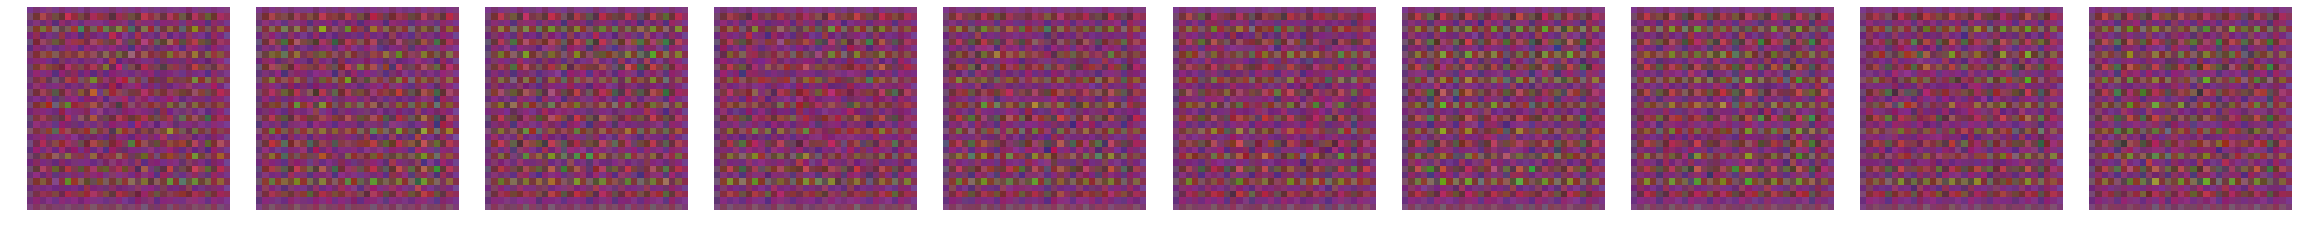

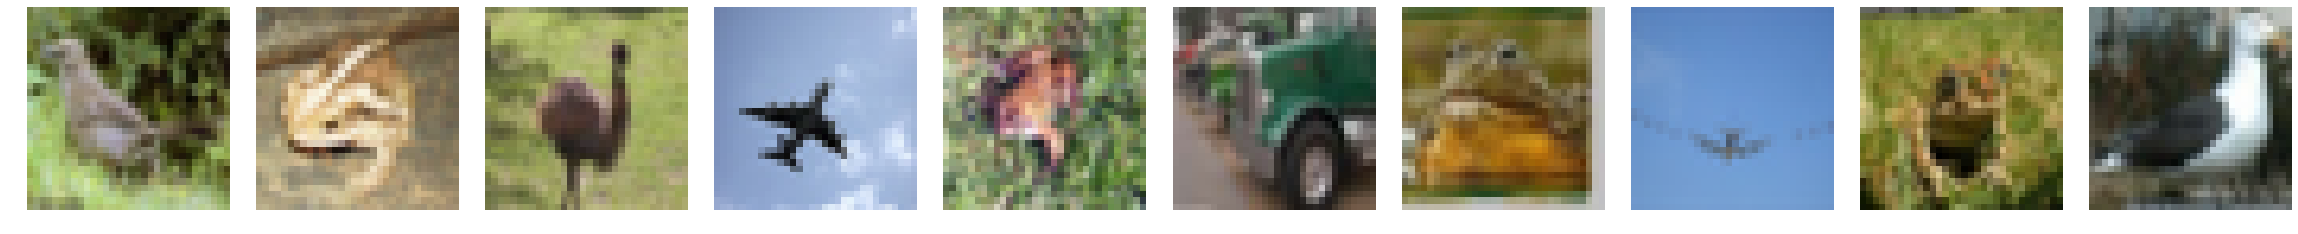

Starting Epoch (201,100000), Time is 3.78, DLoss: 0.11865198612213135, DAcc:0.0, GLoss: 0.1257951259613037, GAcc:0.0
Starting Epoch (202,100000), Time is 0.54, DLoss: 0.11627419292926788, DAcc:0.0, GLoss: 0.1393832117319107, GAcc:0.0
Starting Epoch (203,100000), Time is 0.45, DLoss: 0.12006087601184845, DAcc:0.0, GLoss: 0.15096843242645264, GAcc:0.0
Starting Epoch (204,100000), Time is 0.44, DLoss: 0.1267211139202118, DAcc:0.0, GLoss: 0.12529531121253967, GAcc:0.0
Starting Epoch (205,100000), Time is 0.44, DLoss: 0.12171942740678787, DAcc:0.0, GLoss: 0.14241841435432434, GAcc:0.0
Starting Epoch (206,100000), Time is 0.43, DLoss: 0.13609319925308228, DAcc:0.0, GLoss: 0.15955901145935059, GAcc:0.0
Starting Epoch (207,100000), Time is 0.46, DLoss: 0.1487463414669037, DAcc:0.0, GLoss: 0.16643984615802765, GAcc:0.0
Starting Epoch (208,100000), Time is 0.44, DLoss: 0.12727949023246765, DAcc:0.0, GLoss: 0.21233682334423065, GAcc:0.0
Starting Epoch (209,100000), Time is 0.45, DLoss: 0.16759106

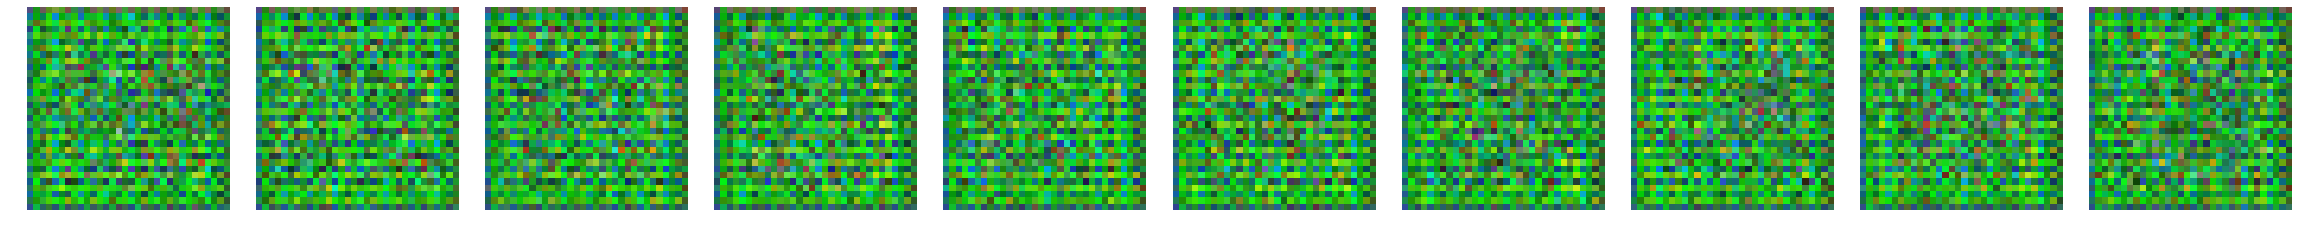

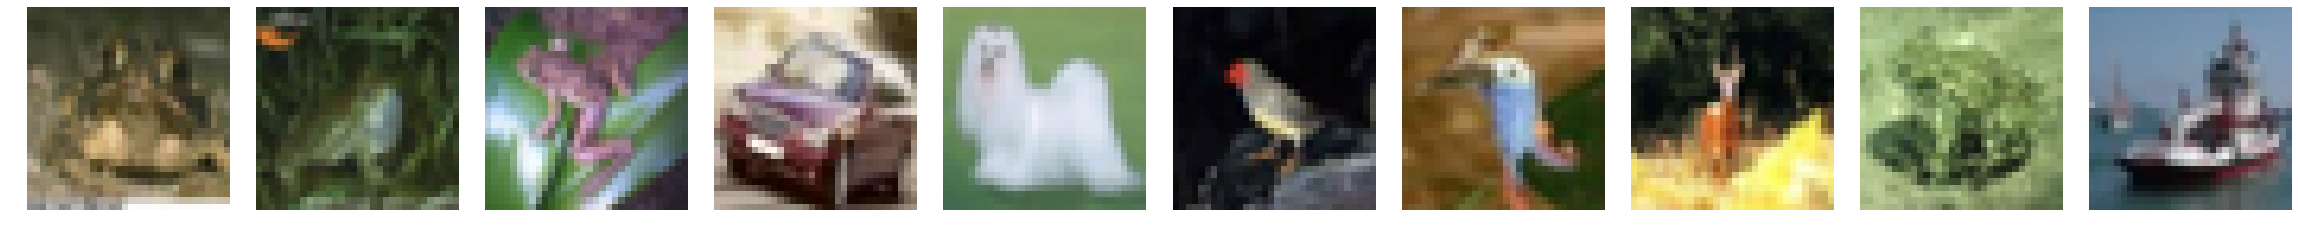

Starting Epoch (301,100000), Time is 3.78, DLoss: 0.1152656078338623, DAcc:0.0, GLoss: 0.11355067789554596, GAcc:0.0
Starting Epoch (302,100000), Time is 0.54, DLoss: 0.11489221453666687, DAcc:0.0, GLoss: 0.11396045982837677, GAcc:0.0
Starting Epoch (303,100000), Time is 0.45, DLoss: 0.11512917280197144, DAcc:0.0, GLoss: 0.11378397047519684, GAcc:0.0
Starting Epoch (304,100000), Time is 0.44, DLoss: 0.1159164309501648, DAcc:0.0, GLoss: 0.11434504389762878, GAcc:0.0
Starting Epoch (305,100000), Time is 0.44, DLoss: 0.11577831208705902, DAcc:0.0, GLoss: 0.11501795053482056, GAcc:0.0
Starting Epoch (306,100000), Time is 0.45, DLoss: 0.11433747410774231, DAcc:0.0, GLoss: 0.11405079066753387, GAcc:0.0
Starting Epoch (307,100000), Time is 0.44, DLoss: 0.11519695818424225, DAcc:0.0, GLoss: 0.11395234614610672, GAcc:0.0
Starting Epoch (308,100000), Time is 0.45, DLoss: 0.11497054994106293, DAcc:0.0, GLoss: 0.11307527124881744, GAcc:0.0
Starting Epoch (309,100000), Time is 0.45, DLoss: 0.114928

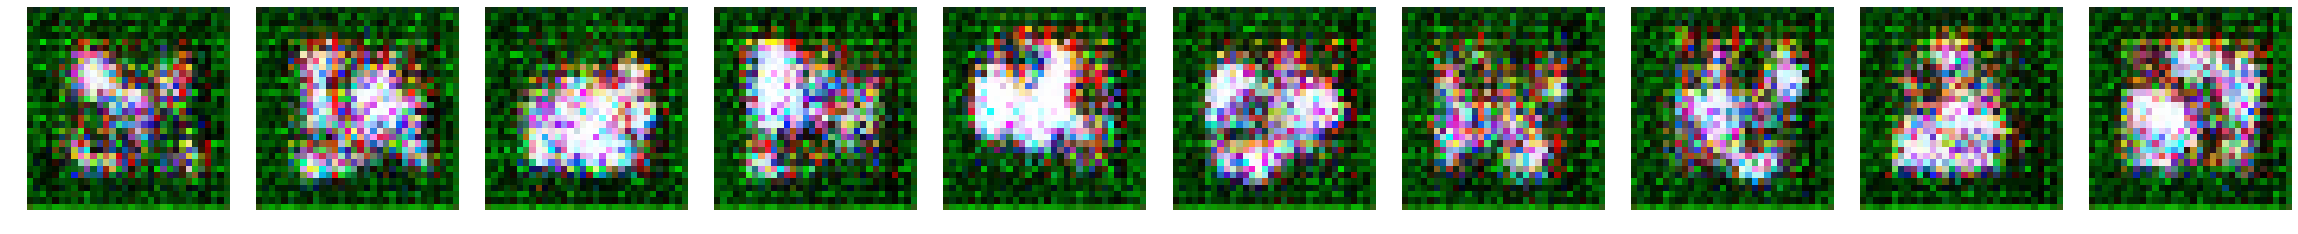

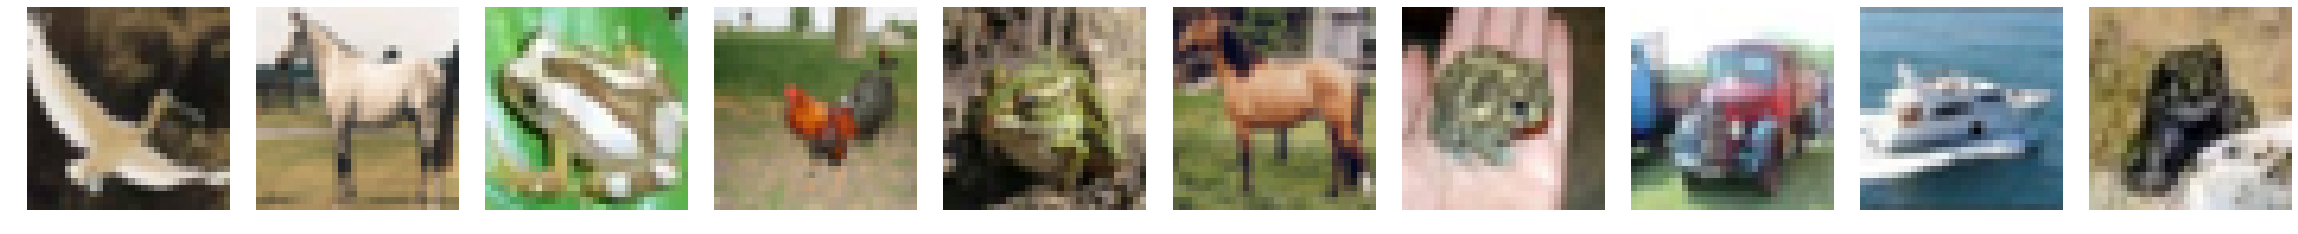

Starting Epoch (401,100000), Time is 3.95, DLoss: 0.34440547227859497, DAcc:0.0, GLoss: 1.3060286045074463, GAcc:0.0
Starting Epoch (402,100000), Time is 0.54, DLoss: 0.26529085636138916, DAcc:0.0, GLoss: 0.24218343198299408, GAcc:0.0
Starting Epoch (403,100000), Time is 0.46, DLoss: 0.22644242644309998, DAcc:0.0, GLoss: 0.1780751794576645, GAcc:0.0
Starting Epoch (404,100000), Time is 0.44, DLoss: 0.20311900973320007, DAcc:0.0, GLoss: 0.7206487059593201, GAcc:0.0
Starting Epoch (405,100000), Time is 0.45, DLoss: 0.14751744270324707, DAcc:0.0, GLoss: 3.3366122245788574, GAcc:0.0
Starting Epoch (406,100000), Time is 0.45, DLoss: 0.1623656153678894, DAcc:0.0, GLoss: 5.453157424926758, GAcc:0.0
Starting Epoch (407,100000), Time is 0.44, DLoss: 0.16480141878128052, DAcc:0.0, GLoss: 6.277791976928711, GAcc:0.0
Starting Epoch (408,100000), Time is 0.44, DLoss: 0.15818843245506287, DAcc:0.0, GLoss: 5.736565589904785, GAcc:0.0
Starting Epoch (409,100000), Time is 0.44, DLoss: 0.149505704641342

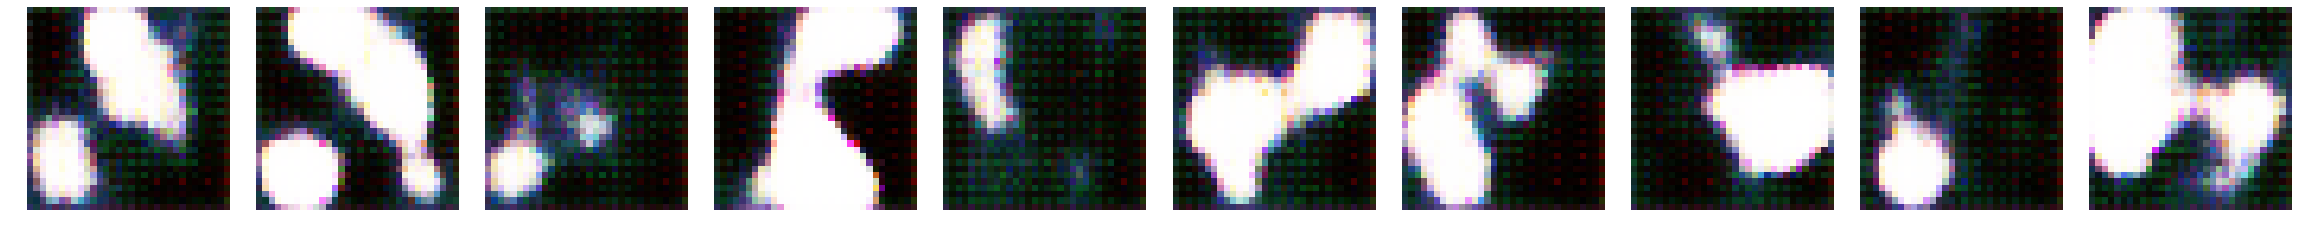

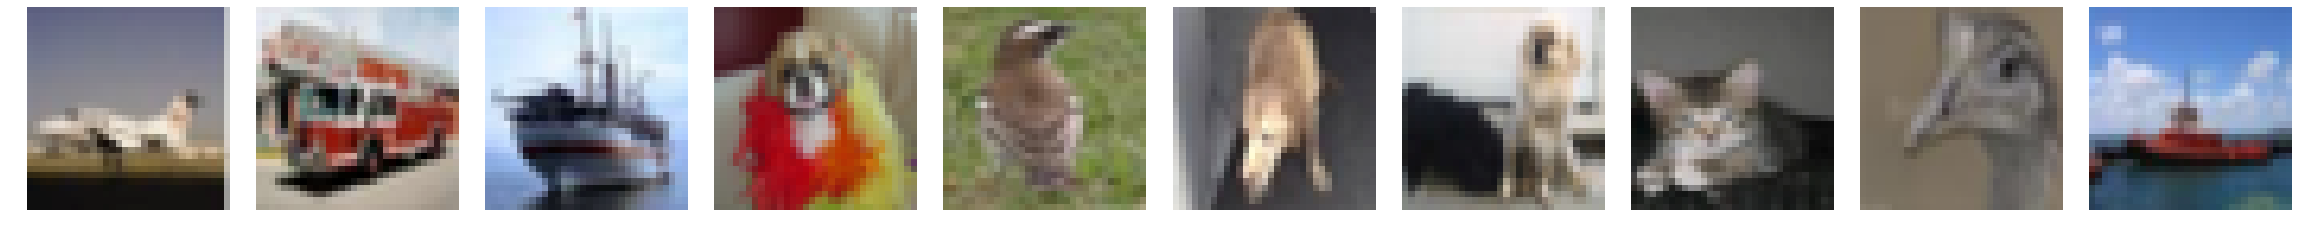

Starting Epoch (501,100000), Time is 3.75, DLoss: 0.17255112528800964, DAcc:0.0, GLoss: 1.4754046201705933, GAcc:0.0
Starting Epoch (502,100000), Time is 0.54, DLoss: 0.16076239943504333, DAcc:0.0, GLoss: 1.7414741516113281, GAcc:0.0
Starting Epoch (503,100000), Time is 0.45, DLoss: 0.13496126234531403, DAcc:0.0, GLoss: 2.5315399169921875, GAcc:0.0
Starting Epoch (504,100000), Time is 0.45, DLoss: 0.18140752613544464, DAcc:0.0, GLoss: 1.9754583835601807, GAcc:0.0
Starting Epoch (505,100000), Time is 0.44, DLoss: 0.14514613151550293, DAcc:0.0, GLoss: 1.4783618450164795, GAcc:0.0
Starting Epoch (506,100000), Time is 0.46, DLoss: 0.1567644327878952, DAcc:0.0, GLoss: 1.619779109954834, GAcc:0.0
Starting Epoch (507,100000), Time is 0.44, DLoss: 0.13725736737251282, DAcc:0.0, GLoss: 2.0543384552001953, GAcc:0.0
Starting Epoch (508,100000), Time is 0.44, DLoss: 0.1376749724149704, DAcc:0.0, GLoss: 2.3330845832824707, GAcc:0.0
Starting Epoch (509,100000), Time is 0.44, DLoss: 0.157943800091743

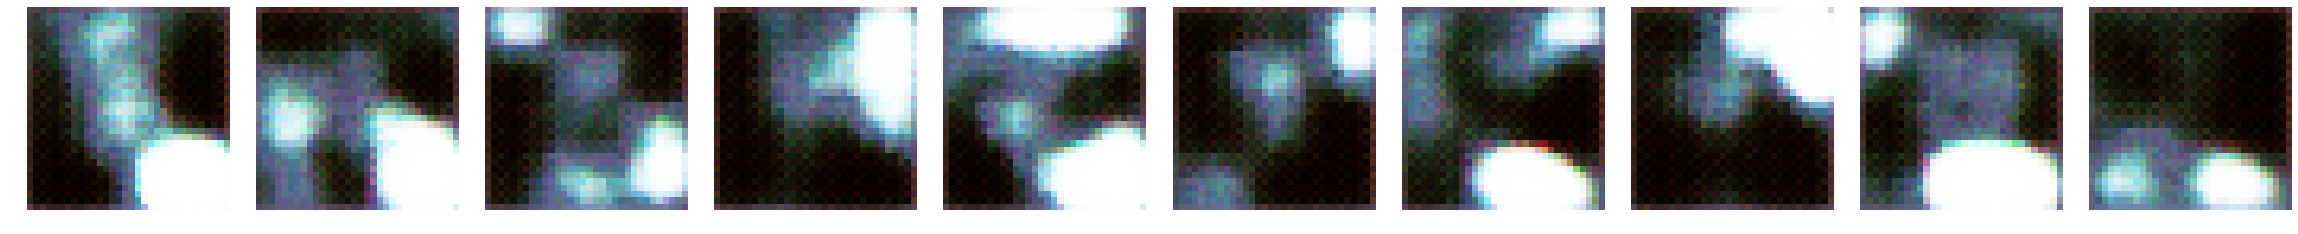

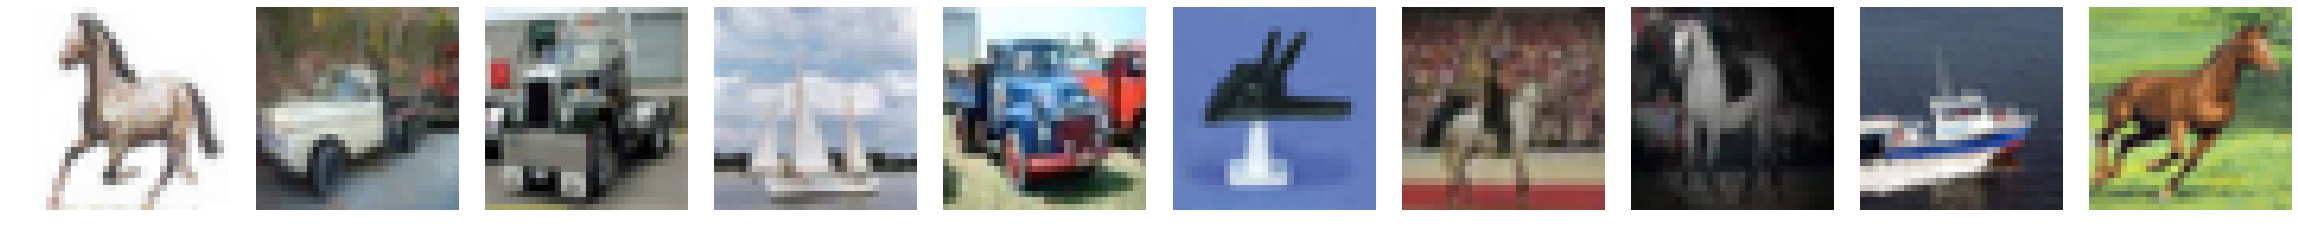

Starting Epoch (601,100000), Time is 3.9, DLoss: 0.1541558802127838, DAcc:0.0, GLoss: 1.1151392459869385, GAcc:0.0
Starting Epoch (602,100000), Time is 0.55, DLoss: 0.15495911240577698, DAcc:0.0, GLoss: 0.7745730876922607, GAcc:0.0
Starting Epoch (603,100000), Time is 0.45, DLoss: 0.14369076490402222, DAcc:0.0, GLoss: 0.9886695742607117, GAcc:0.0
Starting Epoch (604,100000), Time is 0.45, DLoss: 0.14884911477565765, DAcc:0.0, GLoss: 0.698288083076477, GAcc:0.0
Starting Epoch (605,100000), Time is 0.44, DLoss: 0.16430535912513733, DAcc:0.0, GLoss: 0.7178486585617065, GAcc:0.0
Starting Epoch (606,100000), Time is 0.44, DLoss: 0.17177197337150574, DAcc:0.0, GLoss: 0.7277910709381104, GAcc:0.0
Starting Epoch (607,100000), Time is 0.45, DLoss: 0.14958235621452332, DAcc:0.0, GLoss: 0.7518502473831177, GAcc:0.0
Starting Epoch (608,100000), Time is 0.44, DLoss: 0.19071605801582336, DAcc:0.0, GLoss: 0.5927708745002747, GAcc:0.0
Starting Epoch (609,100000), Time is 0.44, DLoss: 0.157757222652435

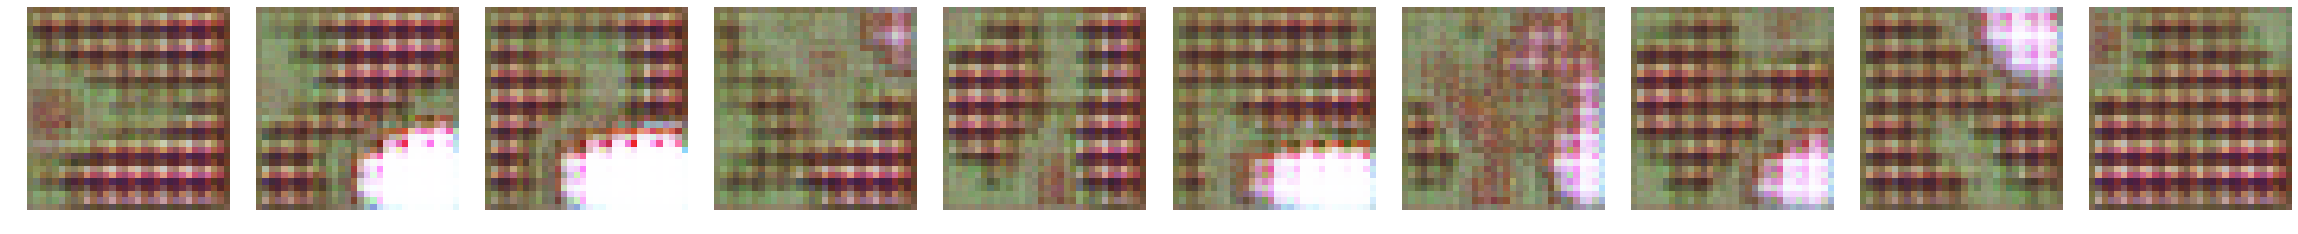

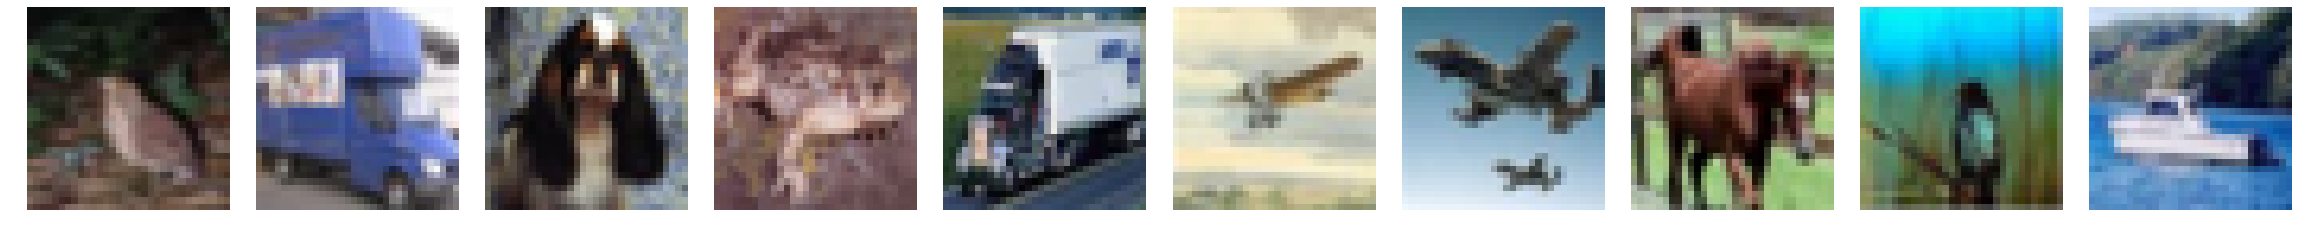

Starting Epoch (701,100000), Time is 3.7, DLoss: 0.15665996074676514, DAcc:0.0, GLoss: 1.9245426654815674, GAcc:0.0
Starting Epoch (702,100000), Time is 0.46, DLoss: 0.16160760819911957, DAcc:0.0, GLoss: 1.6746289730072021, GAcc:0.0
Starting Epoch (703,100000), Time is 0.44, DLoss: 0.17657379806041718, DAcc:0.0, GLoss: 1.4048064947128296, GAcc:0.0
Starting Epoch (704,100000), Time is 0.45, DLoss: 0.16573257744312286, DAcc:0.0, GLoss: 1.4250843524932861, GAcc:0.0
Starting Epoch (705,100000), Time is 0.45, DLoss: 0.15296313166618347, DAcc:0.0, GLoss: 1.9115427732467651, GAcc:0.0
Starting Epoch (706,100000), Time is 0.45, DLoss: 0.1430598646402359, DAcc:0.0, GLoss: 2.297024726867676, GAcc:0.0
Starting Epoch (707,100000), Time is 0.44, DLoss: 0.16428902745246887, DAcc:0.0, GLoss: 1.9133751392364502, GAcc:0.0
Starting Epoch (708,100000), Time is 0.44, DLoss: 0.15719151496887207, DAcc:0.0, GLoss: 1.5168126821517944, GAcc:0.0
Starting Epoch (709,100000), Time is 0.44, DLoss: 0.156383037567138

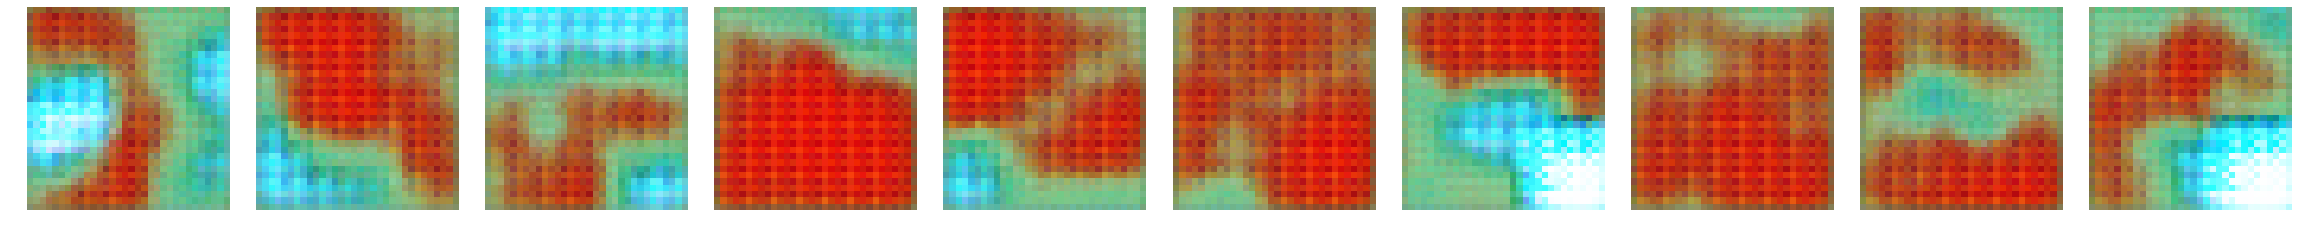

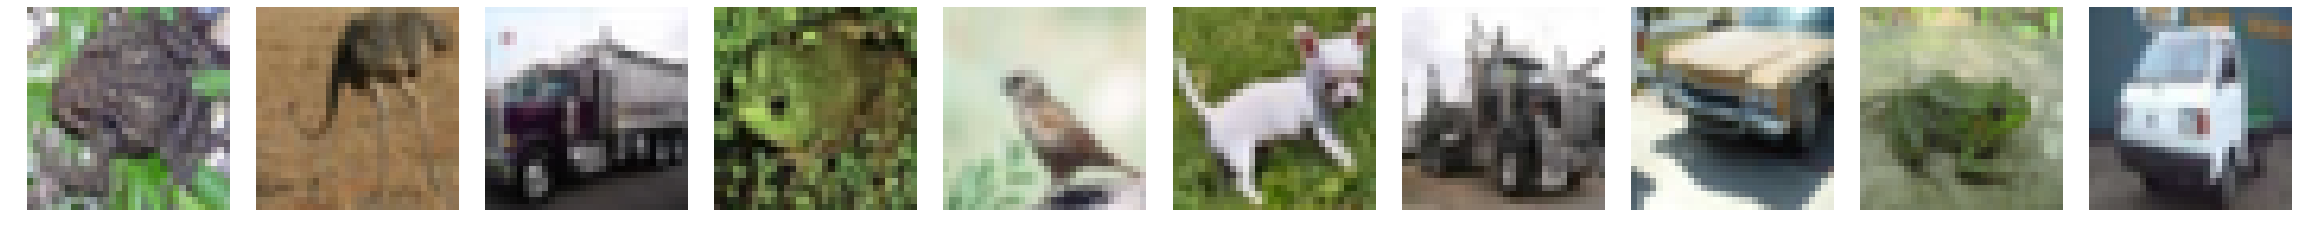

Starting Epoch (801,100000), Time is 3.85, DLoss: 0.13193483650684357, DAcc:0.0, GLoss: 2.8161168098449707, GAcc:0.0
Starting Epoch (802,100000), Time is 0.54, DLoss: 0.1321396380662918, DAcc:0.0, GLoss: 3.293818712234497, GAcc:0.0
Starting Epoch (803,100000), Time is 0.45, DLoss: 0.13563552498817444, DAcc:0.0, GLoss: 2.9444971084594727, GAcc:0.0
Starting Epoch (804,100000), Time is 0.44, DLoss: 0.13427740335464478, DAcc:0.0, GLoss: 2.931204080581665, GAcc:0.0
Starting Epoch (805,100000), Time is 0.44, DLoss: 0.13431411981582642, DAcc:0.0, GLoss: 3.139472246170044, GAcc:0.0
Starting Epoch (806,100000), Time is 0.44, DLoss: 0.13471250236034393, DAcc:0.0, GLoss: 3.1903247833251953, GAcc:0.0
Starting Epoch (807,100000), Time is 0.44, DLoss: 0.17188507318496704, DAcc:0.0, GLoss: 2.6649749279022217, GAcc:0.0
Starting Epoch (808,100000), Time is 0.45, DLoss: 0.1353762000799179, DAcc:0.0, GLoss: 2.9896140098571777, GAcc:0.0
Starting Epoch (809,100000), Time is 0.46, DLoss: 0.1373077630996704,

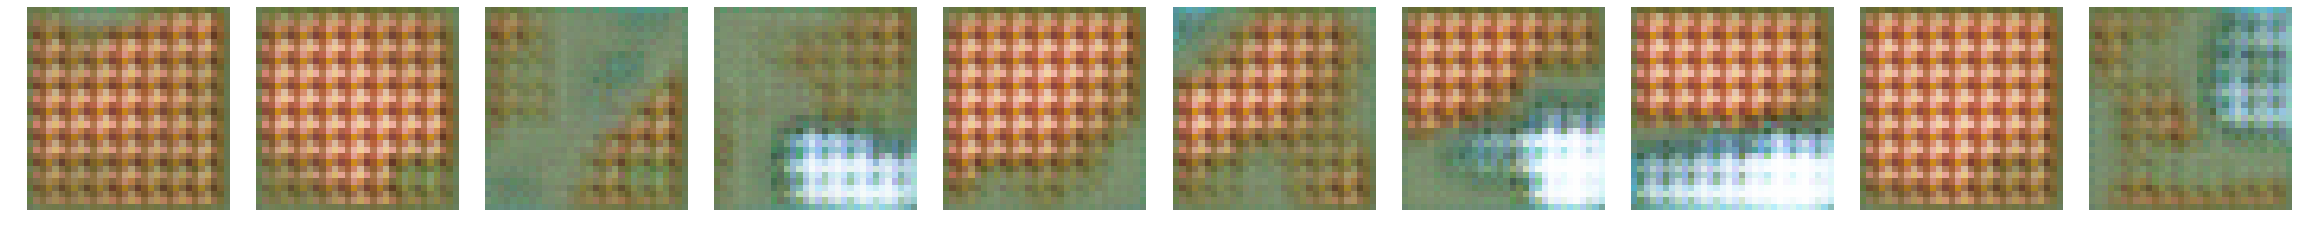

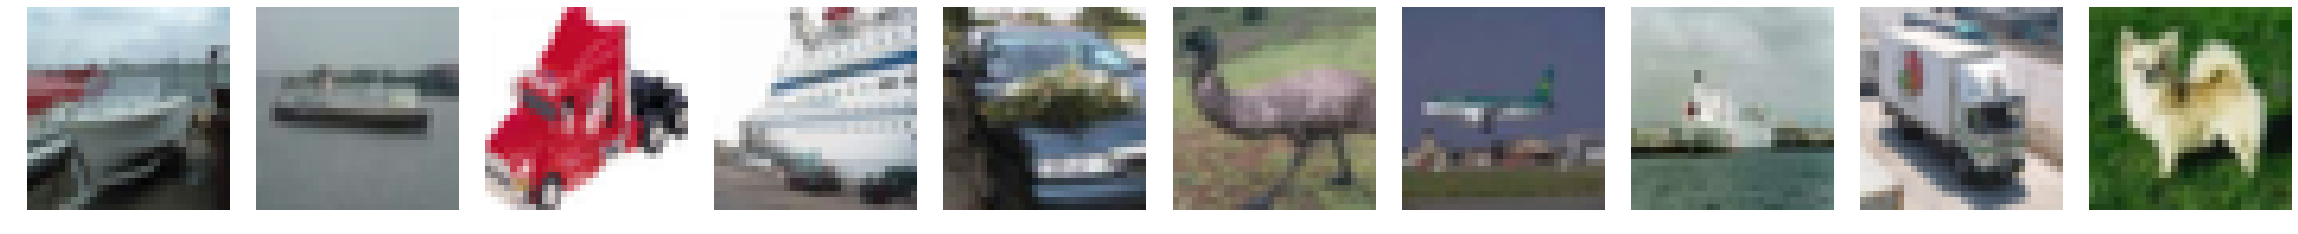

Starting Epoch (901,100000), Time is 3.75, DLoss: 0.14568421244621277, DAcc:0.0, GLoss: 1.97664213180542, GAcc:0.0
Starting Epoch (902,100000), Time is 0.54, DLoss: 0.1385827362537384, DAcc:0.0, GLoss: 1.9182847738265991, GAcc:0.0
Starting Epoch (903,100000), Time is 0.45, DLoss: 0.13857501745224, DAcc:0.0, GLoss: 1.892273187637329, GAcc:0.0
Starting Epoch (904,100000), Time is 0.44, DLoss: 0.14993803203105927, DAcc:0.0, GLoss: 1.6626951694488525, GAcc:0.0
Starting Epoch (905,100000), Time is 0.44, DLoss: 0.13481654226779938, DAcc:0.0, GLoss: 1.753496766090393, GAcc:0.0
Starting Epoch (906,100000), Time is 0.44, DLoss: 0.13677863776683807, DAcc:0.0, GLoss: 1.8554661273956299, GAcc:0.0
Starting Epoch (907,100000), Time is 0.46, DLoss: 0.14810162782669067, DAcc:0.0, GLoss: 1.7049256563186646, GAcc:0.0
Starting Epoch (908,100000), Time is 0.44, DLoss: 0.14586617052555084, DAcc:0.0, GLoss: 1.4066258668899536, GAcc:0.0
Starting Epoch (909,100000), Time is 0.44, DLoss: 0.15127044916152954, D

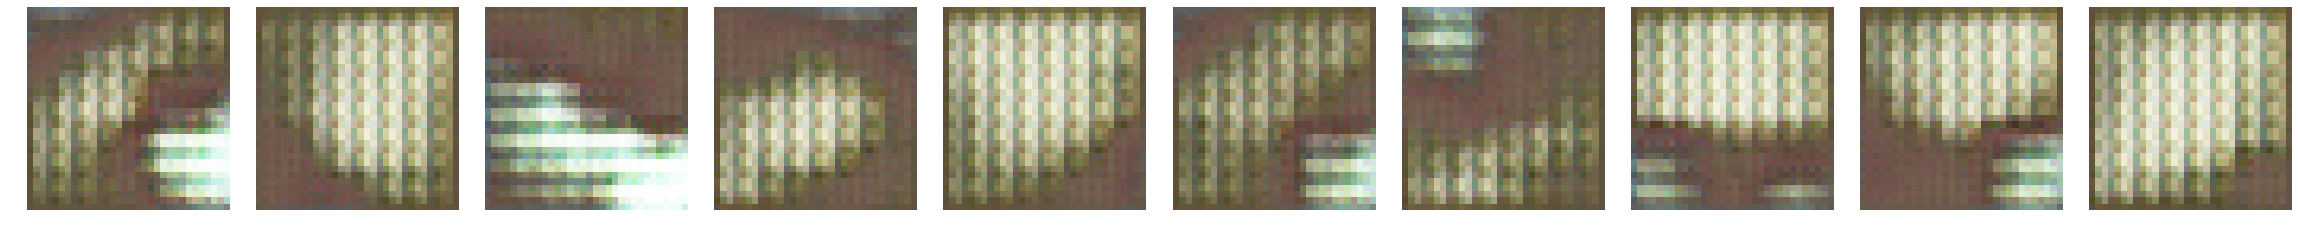

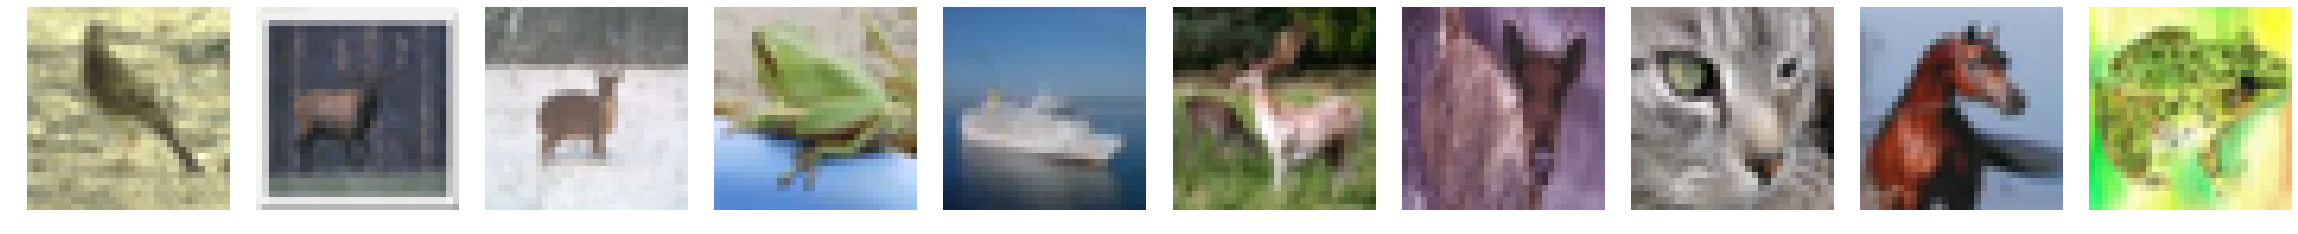

Starting Epoch (1001,100000), Time is 3.95, DLoss: 0.1499669998884201, DAcc:0.0, GLoss: 1.1837224960327148, GAcc:0.0
Starting Epoch (1002,100000), Time is 0.55, DLoss: 0.1557016670703888, DAcc:0.0, GLoss: 1.0679118633270264, GAcc:0.0
Starting Epoch (1003,100000), Time is 0.45, DLoss: 0.1392303705215454, DAcc:0.0, GLoss: 1.4824063777923584, GAcc:0.0
Starting Epoch (1004,100000), Time is 0.44, DLoss: 0.15298202633857727, DAcc:0.0, GLoss: 1.491018295288086, GAcc:0.0
Starting Epoch (1005,100000), Time is 0.45, DLoss: 0.15066184103488922, DAcc:0.0, GLoss: 1.3049633502960205, GAcc:0.0
Starting Epoch (1006,100000), Time is 0.45, DLoss: 0.14156237244606018, DAcc:0.0, GLoss: 1.6550147533416748, GAcc:0.0
Starting Epoch (1007,100000), Time is 0.45, DLoss: 0.1339392513036728, DAcc:0.0, GLoss: 2.114201545715332, GAcc:0.0
Starting Epoch (1008,100000), Time is 0.44, DLoss: 0.14655393362045288, DAcc:0.0, GLoss: 1.7058265209197998, GAcc:0.0
Starting Epoch (1009,100000), Time is 0.46, DLoss: 0.136594399

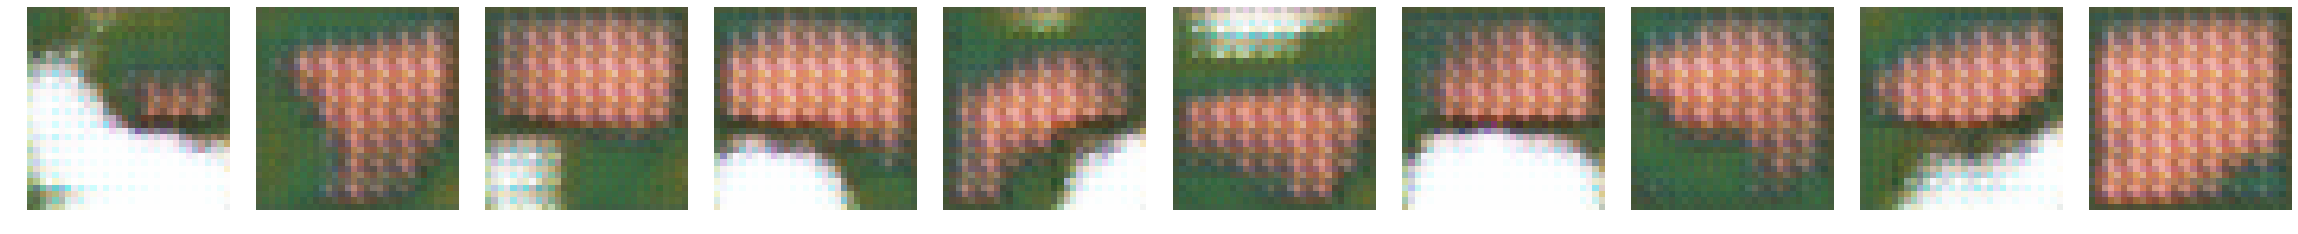

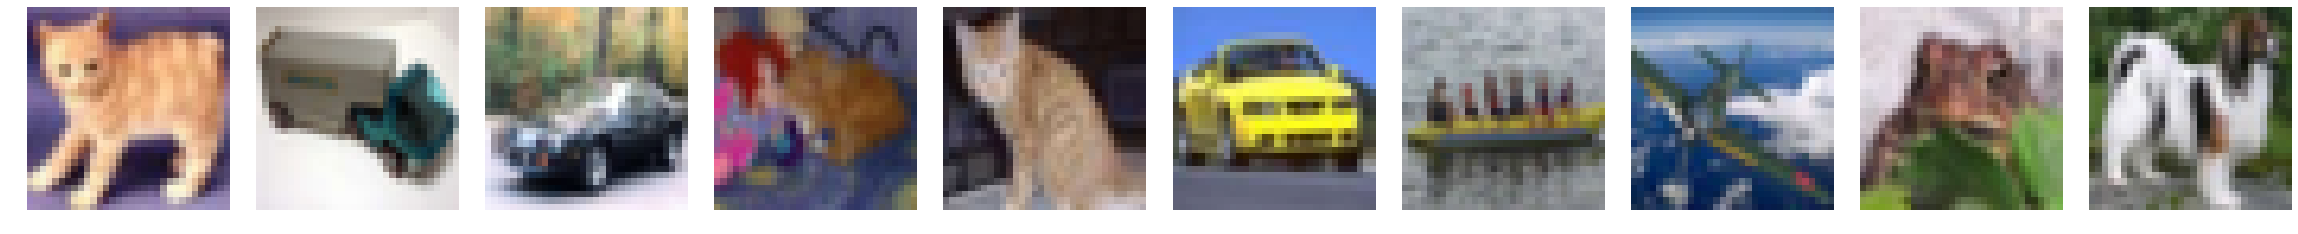

Starting Epoch (1101,100000), Time is 3.8, DLoss: 0.16378752887248993, DAcc:0.0, GLoss: 0.8391227126121521, GAcc:0.0
Starting Epoch (1102,100000), Time is 0.53, DLoss: 0.15995755791664124, DAcc:0.0, GLoss: 0.6864583492279053, GAcc:0.0
Starting Epoch (1103,100000), Time is 0.45, DLoss: 0.19555053114891052, DAcc:0.0, GLoss: 0.5358293056488037, GAcc:0.0
Starting Epoch (1104,100000), Time is 0.44, DLoss: 0.15327391028404236, DAcc:0.0, GLoss: 0.6584511995315552, GAcc:0.0
Starting Epoch (1105,100000), Time is 0.45, DLoss: 0.1620393693447113, DAcc:0.0, GLoss: 0.6277608275413513, GAcc:0.0
Starting Epoch (1106,100000), Time is 0.44, DLoss: 0.1498909890651703, DAcc:0.0, GLoss: 0.5461814403533936, GAcc:0.0
Starting Epoch (1107,100000), Time is 0.45, DLoss: 0.14734990894794464, DAcc:0.0, GLoss: 0.5255130529403687, GAcc:0.0
Starting Epoch (1108,100000), Time is 0.44, DLoss: 0.1509278565645218, DAcc:0.0, GLoss: 0.633678674697876, GAcc:0.0
Starting Epoch (1109,100000), Time is 0.44, DLoss: 0.15282897

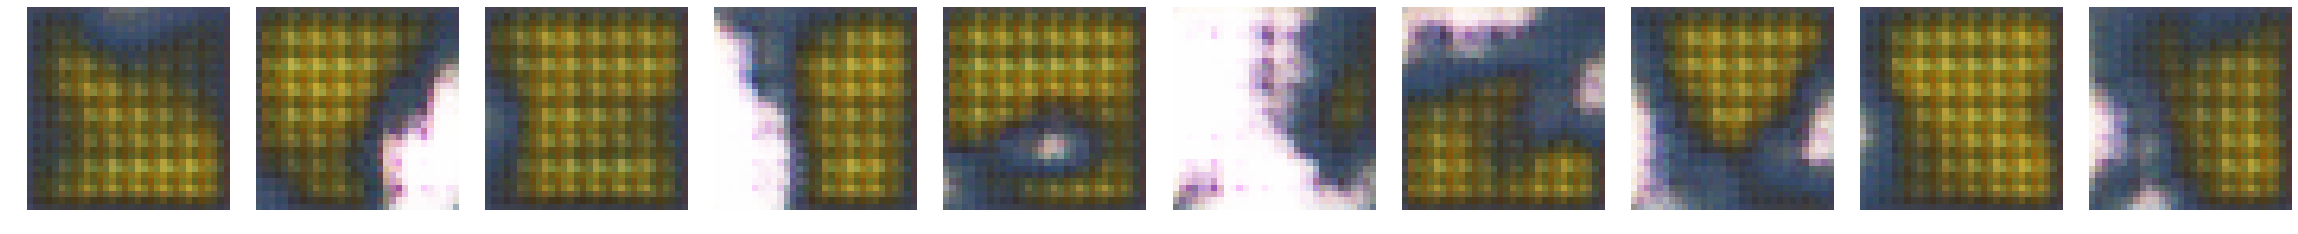

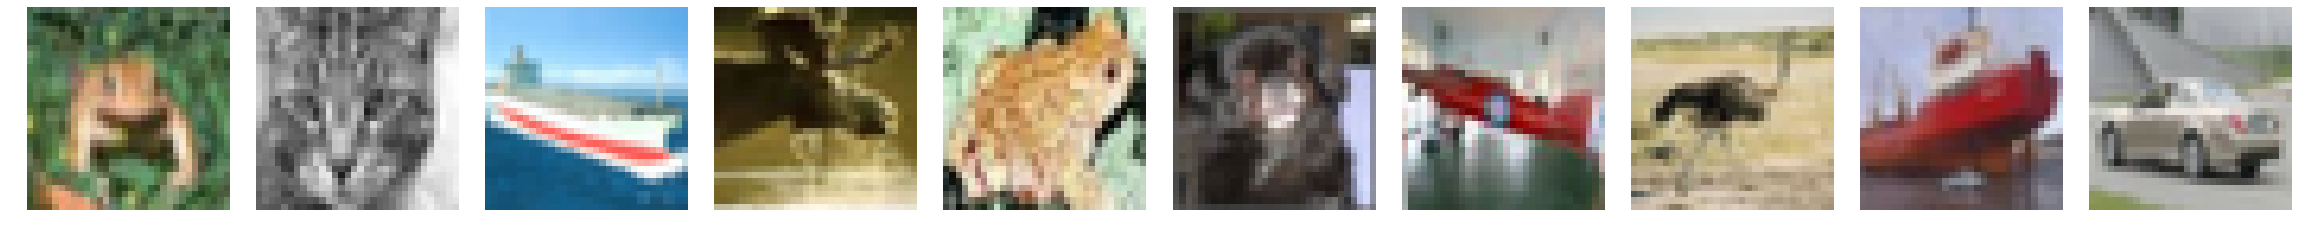

Starting Epoch (1201,100000), Time is 3.81, DLoss: 0.1564050018787384, DAcc:0.0, GLoss: 1.5419278144836426, GAcc:0.0
Starting Epoch (1202,100000), Time is 0.7, DLoss: 0.14998656511306763, DAcc:0.0, GLoss: 1.7846951484680176, GAcc:0.0
Starting Epoch (1203,100000), Time is 0.56, DLoss: 0.1401386260986328, DAcc:0.0, GLoss: 2.062291145324707, GAcc:0.0
Starting Epoch (1204,100000), Time is 0.44, DLoss: 0.14783905446529388, DAcc:0.0, GLoss: 1.524356484413147, GAcc:0.0
Starting Epoch (1205,100000), Time is 0.46, DLoss: 0.17735420167446136, DAcc:0.0, GLoss: 1.2083978652954102, GAcc:0.0
Starting Epoch (1206,100000), Time is 0.44, DLoss: 0.16432435810565948, DAcc:0.0, GLoss: 1.659743070602417, GAcc:0.0
Starting Epoch (1207,100000), Time is 0.44, DLoss: 0.14665111899375916, DAcc:0.0, GLoss: 2.0757217407226562, GAcc:0.0
Starting Epoch (1208,100000), Time is 0.45, DLoss: 0.15232831239700317, DAcc:0.0, GLoss: 1.2920536994934082, GAcc:0.0
Starting Epoch (1209,100000), Time is 0.45, DLoss: 0.139567732

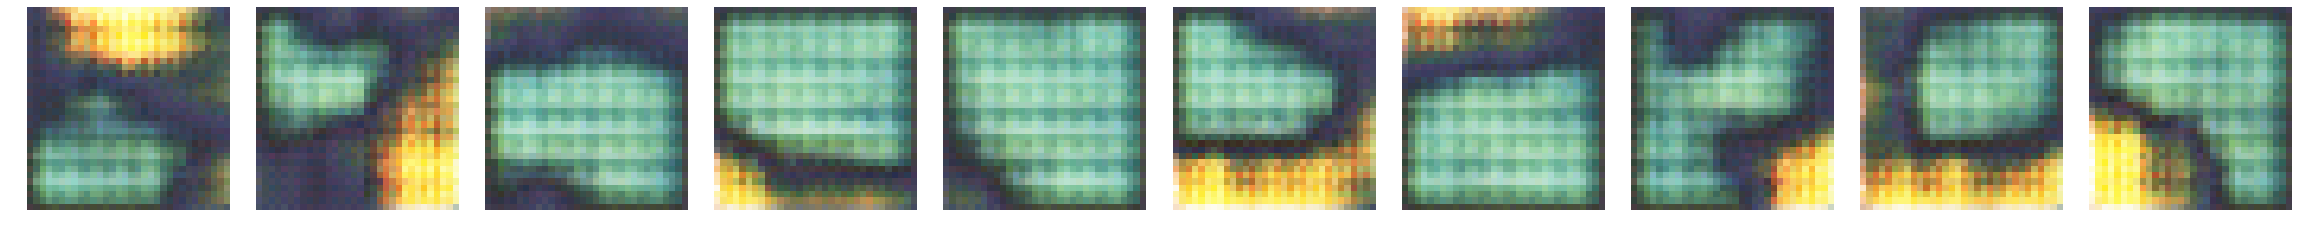

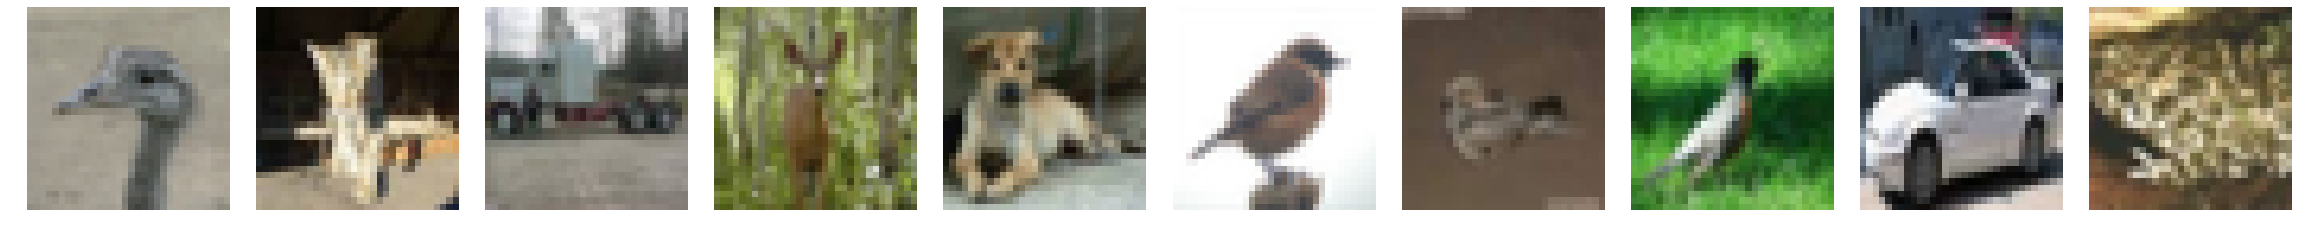

Starting Epoch (1301,100000), Time is 3.87, DLoss: 0.1569608449935913, DAcc:0.0, GLoss: 0.5365855693817139, GAcc:0.0
Starting Epoch (1302,100000), Time is 0.55, DLoss: 0.13044233620166779, DAcc:0.0, GLoss: 0.46604907512664795, GAcc:0.0
Starting Epoch (1303,100000), Time is 0.46, DLoss: 0.14057452976703644, DAcc:0.0, GLoss: 0.4487764835357666, GAcc:0.0
Starting Epoch (1304,100000), Time is 0.43, DLoss: 0.14947369694709778, DAcc:0.0, GLoss: 0.43678075075149536, GAcc:0.0
Starting Epoch (1305,100000), Time is 0.44, DLoss: 0.1361313760280609, DAcc:0.0, GLoss: 0.5385688543319702, GAcc:0.0
Starting Epoch (1306,100000), Time is 0.43, DLoss: 0.157846599817276, DAcc:0.0, GLoss: 0.508429765701294, GAcc:0.0
Starting Epoch (1307,100000), Time is 0.45, DLoss: 0.13619090616703033, DAcc:0.0, GLoss: 0.6289700269699097, GAcc:0.0
Starting Epoch (1308,100000), Time is 0.44, DLoss: 0.14142991602420807, DAcc:0.0, GLoss: 0.6679245829582214, GAcc:0.0
Starting Epoch (1309,100000), Time is 0.45, DLoss: 0.145708

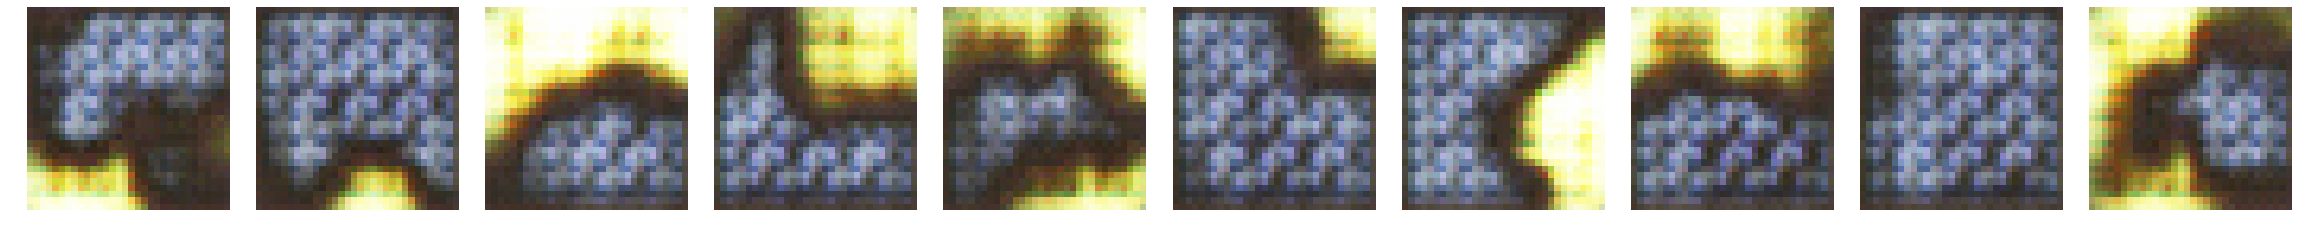

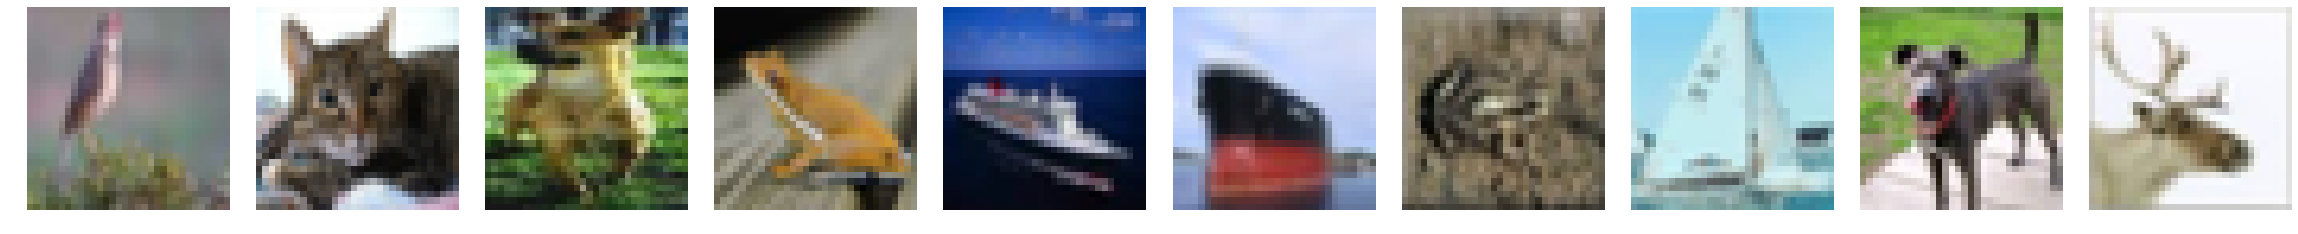

Starting Epoch (1401,100000), Time is 3.76, DLoss: 0.2508805990219116, DAcc:0.0, GLoss: 0.9877145290374756, GAcc:0.0
Starting Epoch (1402,100000), Time is 0.54, DLoss: 0.19211089611053467, DAcc:0.0, GLoss: 1.3331748247146606, GAcc:0.0
Starting Epoch (1403,100000), Time is 0.45, DLoss: 0.21604666113853455, DAcc:0.0, GLoss: 1.7103374004364014, GAcc:0.0
Starting Epoch (1404,100000), Time is 0.46, DLoss: 0.211758092045784, DAcc:0.0, GLoss: 1.5486923456192017, GAcc:0.0
Starting Epoch (1405,100000), Time is 0.44, DLoss: 0.22241458296775818, DAcc:0.0, GLoss: 1.3075305223464966, GAcc:0.0
Starting Epoch (1406,100000), Time is 0.45, DLoss: 0.2456386536359787, DAcc:0.0, GLoss: 1.2944496870040894, GAcc:0.0
Starting Epoch (1407,100000), Time is 0.45, DLoss: 0.21121296286582947, DAcc:0.0, GLoss: 1.6183515787124634, GAcc:0.0
Starting Epoch (1408,100000), Time is 0.45, DLoss: 0.1759791076183319, DAcc:0.0, GLoss: 1.9766418933868408, GAcc:0.0
Starting Epoch (1409,100000), Time is 0.44, DLoss: 0.17620731

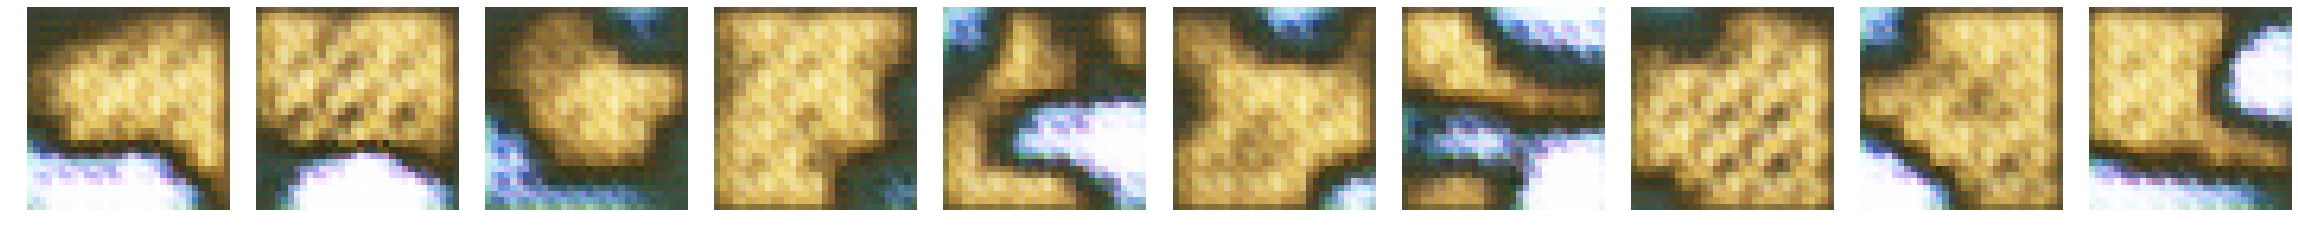

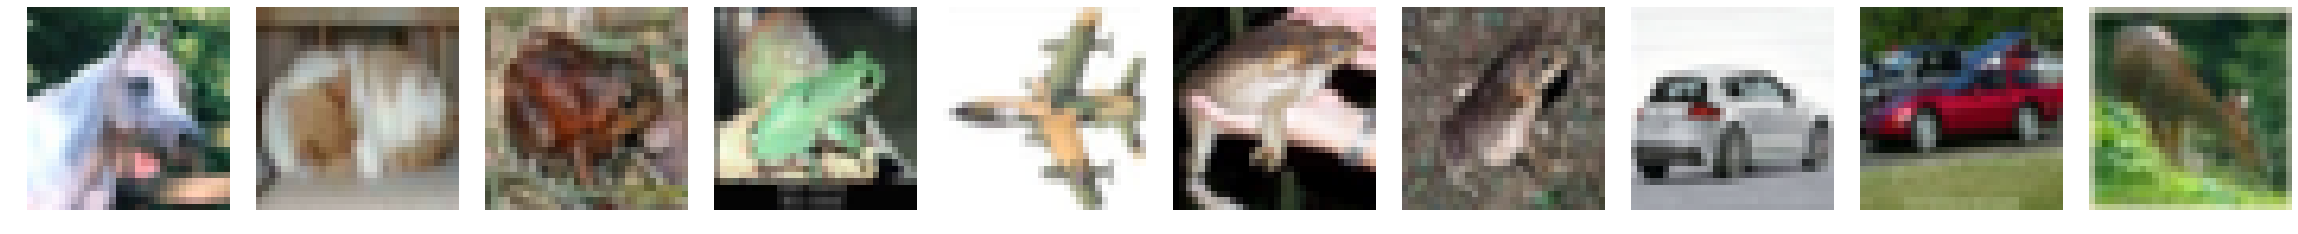

Starting Epoch (1501,100000), Time is 3.94, DLoss: 0.14639322459697723, DAcc:0.0, GLoss: 0.8204712867736816, GAcc:0.0
Starting Epoch (1502,100000), Time is 0.54, DLoss: 0.16235005855560303, DAcc:0.0, GLoss: 0.62646484375, GAcc:0.0
Starting Epoch (1503,100000), Time is 0.45, DLoss: 0.1959225982427597, DAcc:0.0, GLoss: 0.7061645984649658, GAcc:0.0
Starting Epoch (1504,100000), Time is 0.45, DLoss: 0.15075676143169403, DAcc:0.0, GLoss: 1.536474585533142, GAcc:0.0
Starting Epoch (1505,100000), Time is 0.44, DLoss: 0.14473775029182434, DAcc:0.0, GLoss: 1.9871799945831299, GAcc:0.0
Starting Epoch (1506,100000), Time is 0.45, DLoss: 0.16550585627555847, DAcc:0.0, GLoss: 1.7003324031829834, GAcc:0.0
Starting Epoch (1507,100000), Time is 0.44, DLoss: 0.14943307638168335, DAcc:0.0, GLoss: 1.0000015497207642, GAcc:0.0
Starting Epoch (1508,100000), Time is 0.43, DLoss: 0.16779673099517822, DAcc:0.0, GLoss: 0.5741273760795593, GAcc:0.0
Starting Epoch (1509,100000), Time is 0.44, DLoss: 0.1486639529

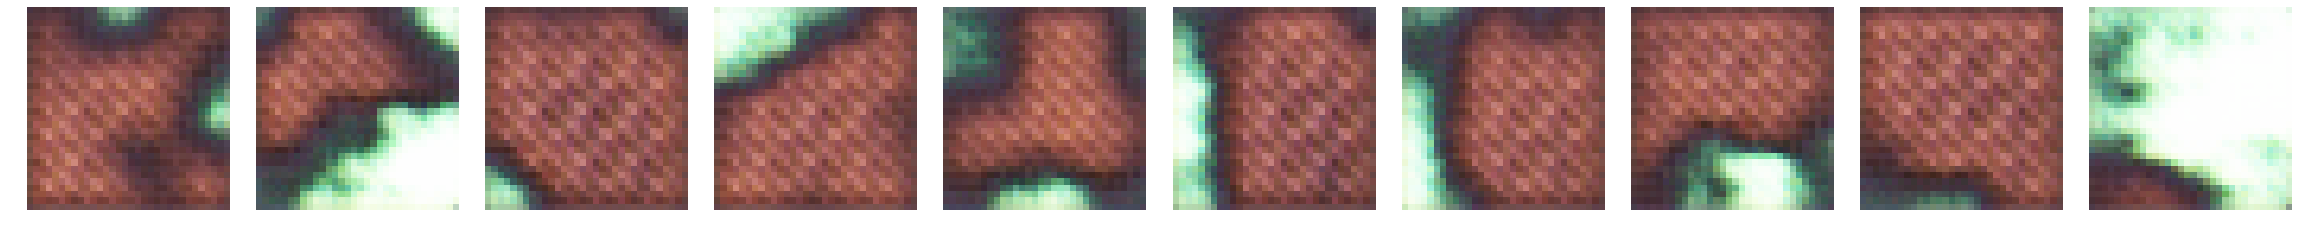

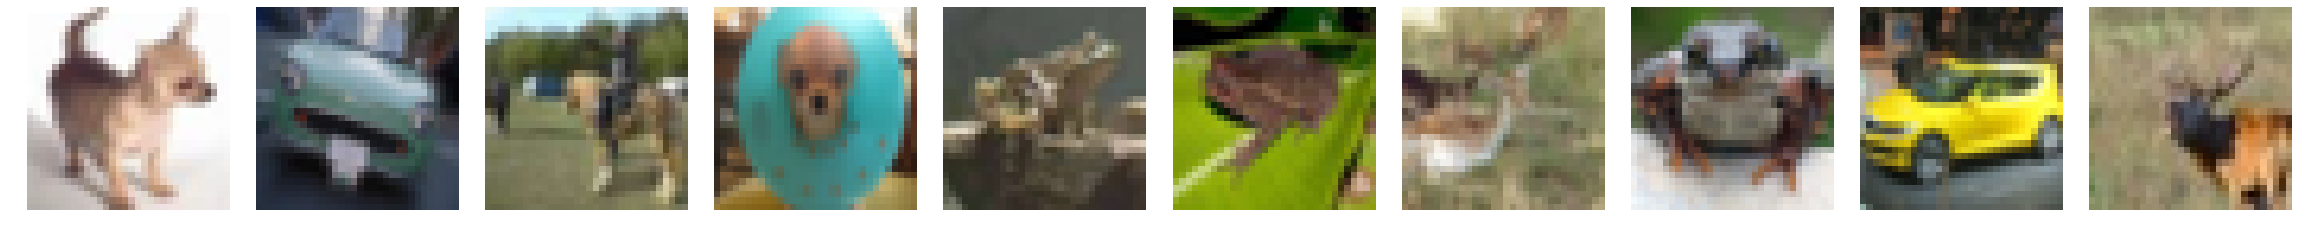

Starting Epoch (1601,100000), Time is 3.78, DLoss: 0.1619463562965393, DAcc:0.0, GLoss: 4.200521469116211, GAcc:0.0
Starting Epoch (1602,100000), Time is 0.48, DLoss: 0.1486181616783142, DAcc:0.0, GLoss: 3.862529754638672, GAcc:0.0
Starting Epoch (1603,100000), Time is 0.44, DLoss: 0.18966710567474365, DAcc:0.0, GLoss: 2.6915502548217773, GAcc:0.0
Starting Epoch (1604,100000), Time is 0.43, DLoss: 0.19444069266319275, DAcc:0.0, GLoss: 2.651021957397461, GAcc:0.0
Starting Epoch (1605,100000), Time is 0.45, DLoss: 0.1724557876586914, DAcc:0.0, GLoss: 3.7986087799072266, GAcc:0.0
Starting Epoch (1606,100000), Time is 0.44, DLoss: 0.15473009645938873, DAcc:0.0, GLoss: 4.2896342277526855, GAcc:0.0
Starting Epoch (1607,100000), Time is 0.45, DLoss: 0.20504848659038544, DAcc:0.0, GLoss: 3.6413967609405518, GAcc:0.0
Starting Epoch (1608,100000), Time is 0.44, DLoss: 0.17988210916519165, DAcc:0.0, GLoss: 2.7672348022460938, GAcc:0.0
Starting Epoch (1609,100000), Time is 0.45, DLoss: 0.206611171

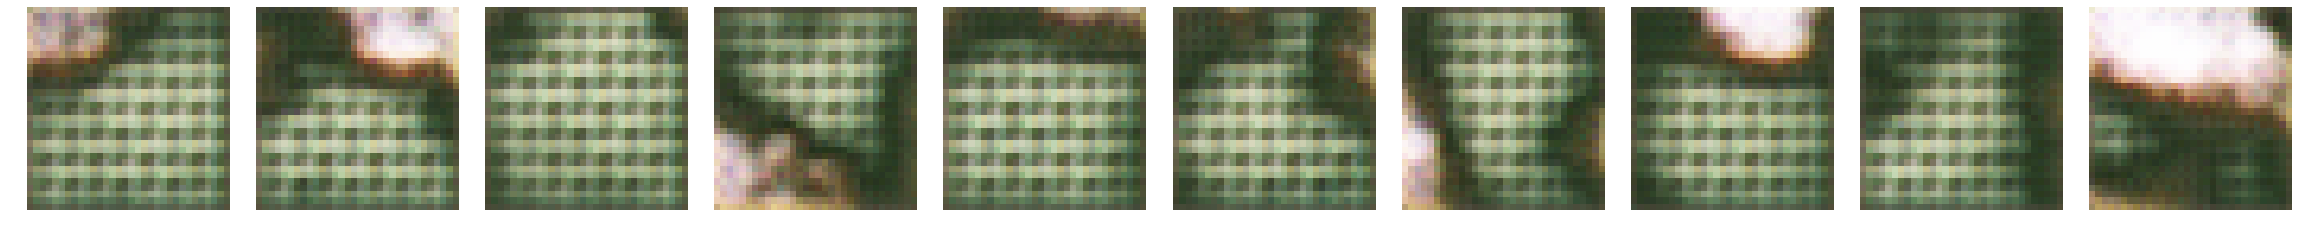

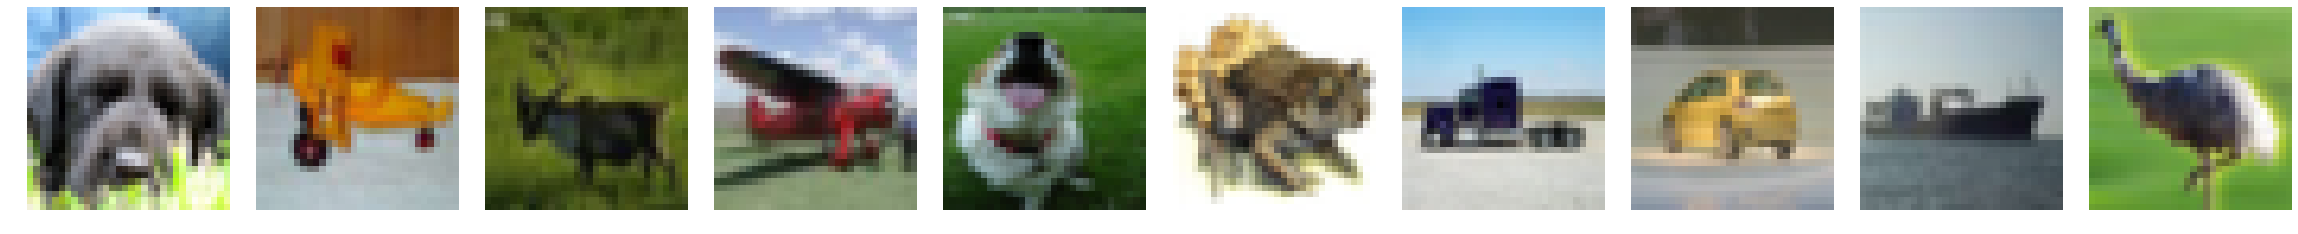

Starting Epoch (1701,100000), Time is 3.93, DLoss: 0.1362191140651703, DAcc:0.0, GLoss: 2.2742087841033936, GAcc:0.0
Starting Epoch (1702,100000), Time is 0.54, DLoss: 0.15114825963974, DAcc:0.0, GLoss: 2.0592613220214844, GAcc:0.0
Starting Epoch (1703,100000), Time is 0.45, DLoss: 0.1598915457725525, DAcc:0.0, GLoss: 1.5533361434936523, GAcc:0.0
Starting Epoch (1704,100000), Time is 0.46, DLoss: 0.152705118060112, DAcc:0.0, GLoss: 1.6934492588043213, GAcc:0.0
Starting Epoch (1705,100000), Time is 0.44, DLoss: 0.1523628830909729, DAcc:0.0, GLoss: 1.8211193084716797, GAcc:0.0
Starting Epoch (1706,100000), Time is 0.46, DLoss: 0.19012907147407532, DAcc:0.0, GLoss: 1.3713874816894531, GAcc:0.0
Starting Epoch (1707,100000), Time is 0.47, DLoss: 0.1649419218301773, DAcc:0.0, GLoss: 1.5535703897476196, GAcc:0.0
Starting Epoch (1708,100000), Time is 0.46, DLoss: 0.16018228232860565, DAcc:0.0, GLoss: 2.0341062545776367, GAcc:0.0
Starting Epoch (1709,100000), Time is 0.45, DLoss: 0.163205787539

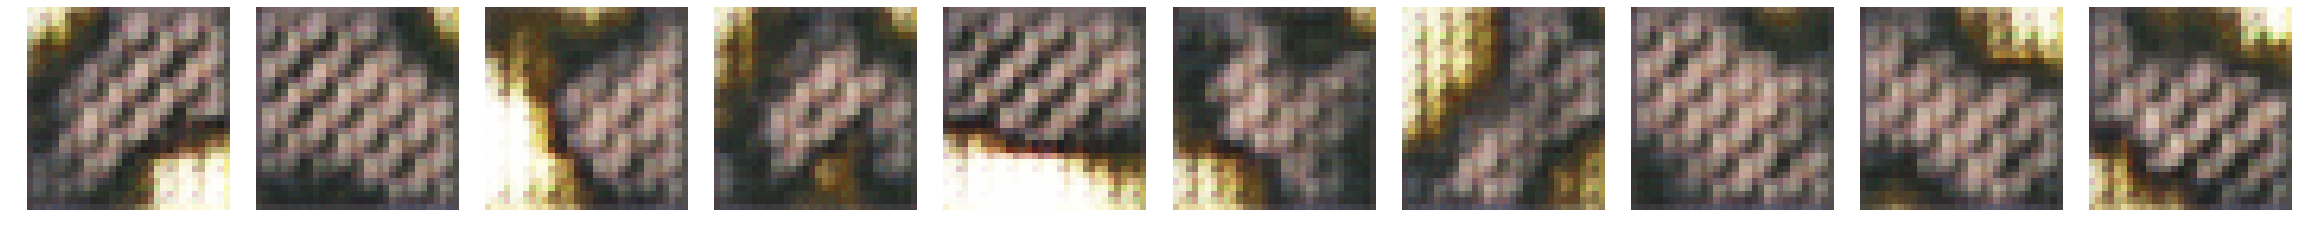

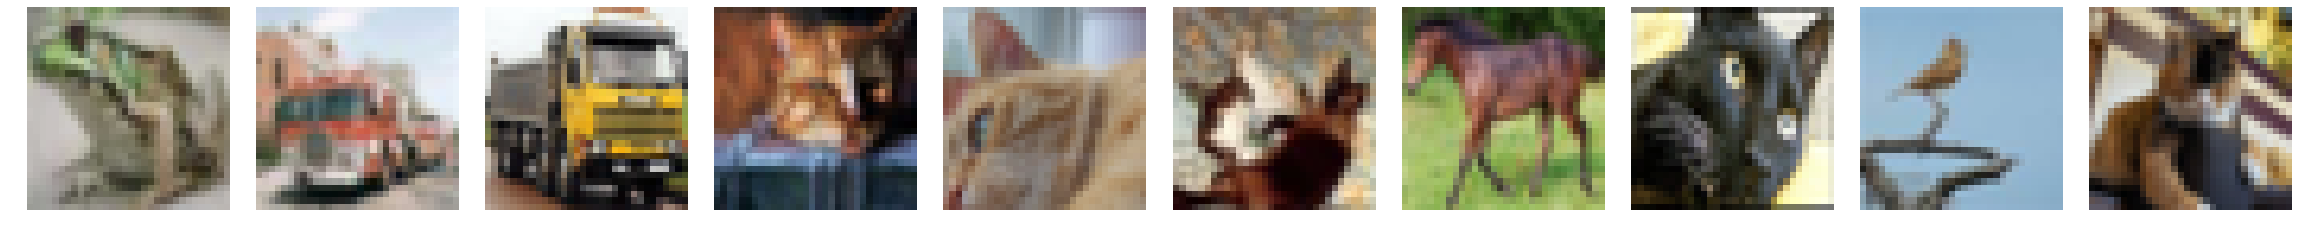

Starting Epoch (1801,100000), Time is 3.72, DLoss: 0.34366488456726074, DAcc:0.0, GLoss: 2.385420799255371, GAcc:0.0
Starting Epoch (1802,100000), Time is 0.56, DLoss: 0.1848912537097931, DAcc:0.0, GLoss: 4.274178504943848, GAcc:0.0
Starting Epoch (1803,100000), Time is 0.45, DLoss: 0.322262704372406, DAcc:0.0, GLoss: 2.281055212020874, GAcc:0.0
Starting Epoch (1804,100000), Time is 0.44, DLoss: 0.2622881233692169, DAcc:0.0, GLoss: 1.9641618728637695, GAcc:0.0
Starting Epoch (1805,100000), Time is 0.44, DLoss: 0.1668829619884491, DAcc:0.0, GLoss: 3.3878486156463623, GAcc:0.0
Starting Epoch (1806,100000), Time is 0.44, DLoss: 0.1661517173051834, DAcc:0.0, GLoss: 3.897799015045166, GAcc:0.0
Starting Epoch (1807,100000), Time is 0.45, DLoss: 0.19751423597335815, DAcc:0.0, GLoss: 3.463999032974243, GAcc:0.0
Starting Epoch (1808,100000), Time is 0.44, DLoss: 0.17023125290870667, DAcc:0.0, GLoss: 2.3994102478027344, GAcc:0.0
Starting Epoch (1809,100000), Time is 0.44, DLoss: 0.18161633610725

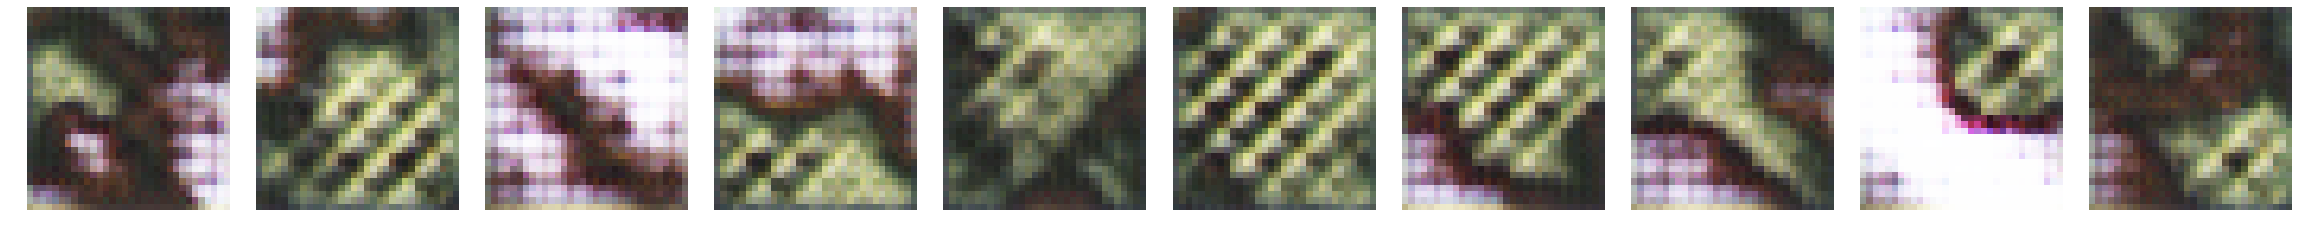

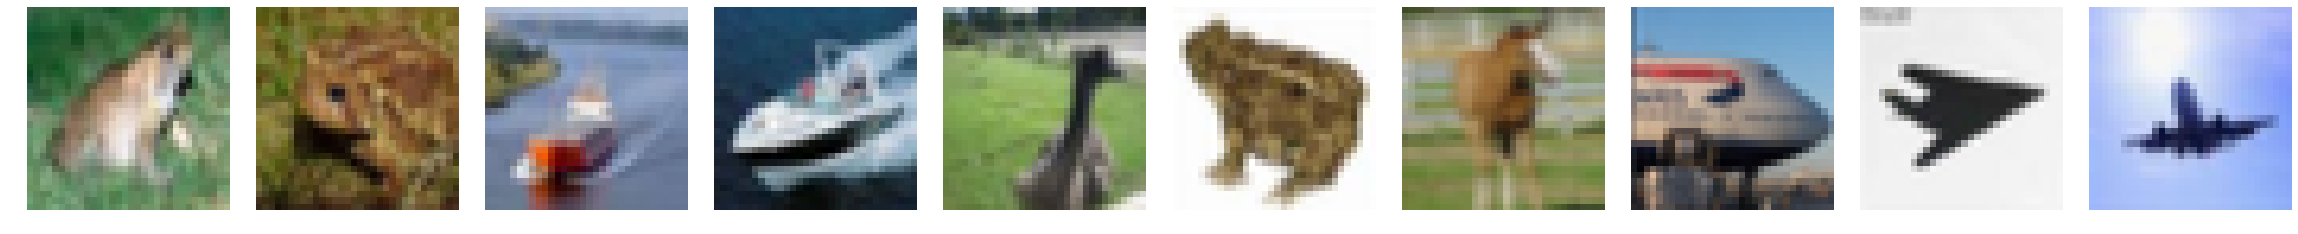

Starting Epoch (1901,100000), Time is 3.91, DLoss: 0.19236691296100616, DAcc:0.0, GLoss: 1.8582618236541748, GAcc:0.0
Starting Epoch (1902,100000), Time is 0.55, DLoss: 0.23286917805671692, DAcc:0.0, GLoss: 1.3866500854492188, GAcc:0.0
Starting Epoch (1903,100000), Time is 0.45, DLoss: 0.18605303764343262, DAcc:0.0, GLoss: 1.0356154441833496, GAcc:0.0
Starting Epoch (1904,100000), Time is 0.44, DLoss: 0.21170350909233093, DAcc:0.0, GLoss: 1.0778558254241943, GAcc:0.0
Starting Epoch (1905,100000), Time is 0.44, DLoss: 0.23755604028701782, DAcc:0.0, GLoss: 1.0544670820236206, GAcc:0.0
Starting Epoch (1906,100000), Time is 0.43, DLoss: 0.23376144468784332, DAcc:0.0, GLoss: 1.1699254512786865, GAcc:0.0
Starting Epoch (1907,100000), Time is 0.44, DLoss: 0.1907476782798767, DAcc:0.0, GLoss: 1.6734119653701782, GAcc:0.0
Starting Epoch (1908,100000), Time is 0.44, DLoss: 0.20443572103977203, DAcc:0.0, GLoss: 1.1909886598587036, GAcc:0.0
Starting Epoch (1909,100000), Time is 0.45, DLoss: 0.1953

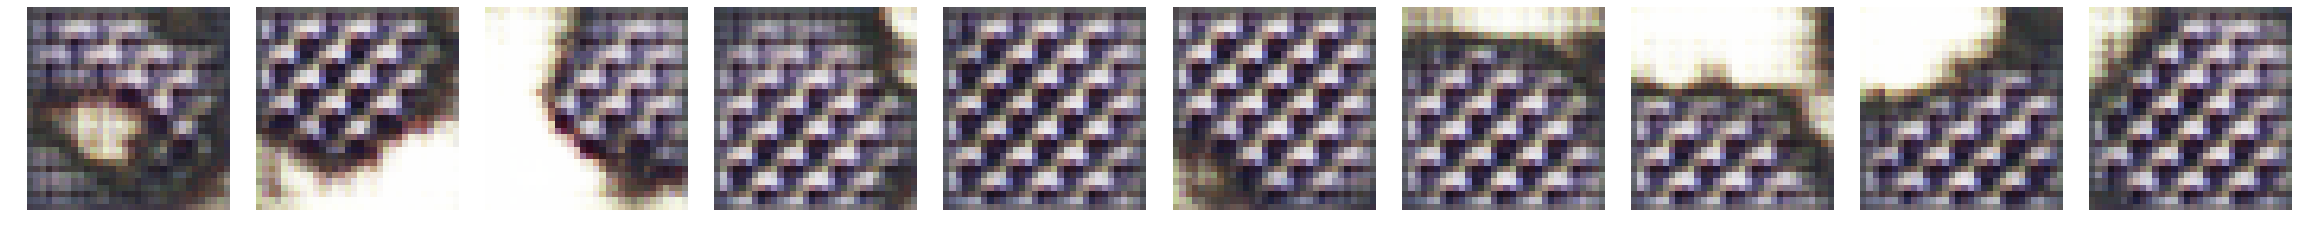

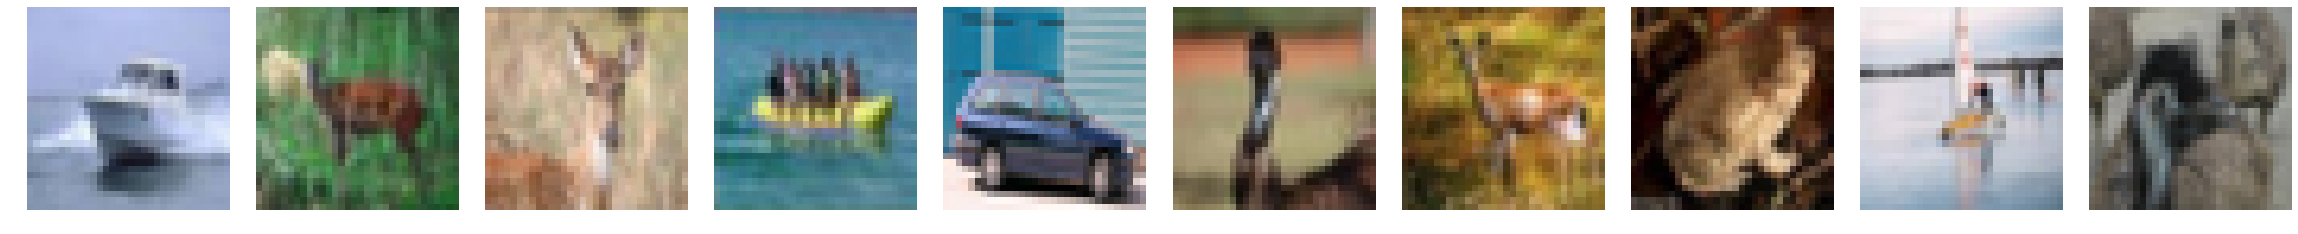

Starting Epoch (2001,100000), Time is 3.75, DLoss: 0.1403799057006836, DAcc:0.0, GLoss: 1.4378275871276855, GAcc:0.0
Starting Epoch (2002,100000), Time is 0.55, DLoss: 0.15798084437847137, DAcc:0.0, GLoss: 1.1966350078582764, GAcc:0.0
Starting Epoch (2003,100000), Time is 0.45, DLoss: 0.1637108027935028, DAcc:0.0, GLoss: 1.038475513458252, GAcc:0.0
Starting Epoch (2004,100000), Time is 0.45, DLoss: 0.14716601371765137, DAcc:0.0, GLoss: 1.2575687170028687, GAcc:0.0
Starting Epoch (2005,100000), Time is 0.44, DLoss: 0.15676337480545044, DAcc:0.0, GLoss: 1.1726725101470947, GAcc:0.0
Starting Epoch (2006,100000), Time is 0.45, DLoss: 0.16119977831840515, DAcc:0.0, GLoss: 1.0513449907302856, GAcc:0.0
Starting Epoch (2007,100000), Time is 0.44, DLoss: 0.15455618500709534, DAcc:0.0, GLoss: 0.9589396715164185, GAcc:0.0
Starting Epoch (2008,100000), Time is 0.44, DLoss: 0.14717347919940948, DAcc:0.0, GLoss: 1.1873059272766113, GAcc:0.0
Starting Epoch (2009,100000), Time is 0.44, DLoss: 0.143261

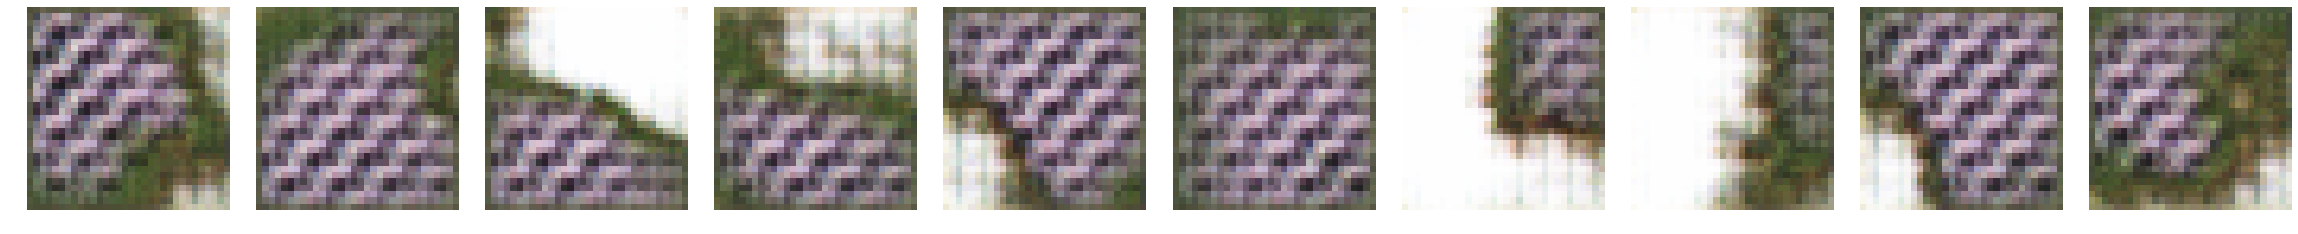

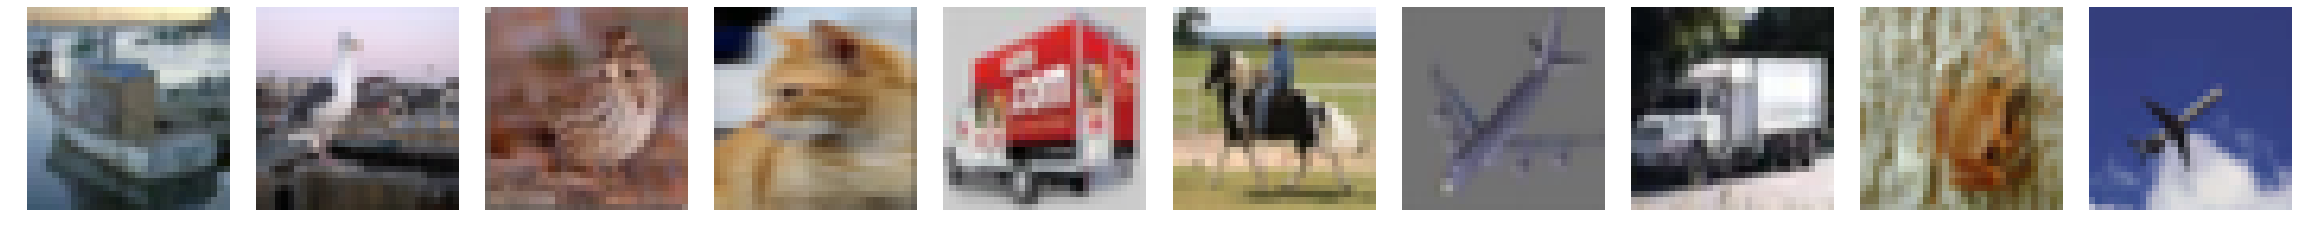

Starting Epoch (2101,100000), Time is 3.74, DLoss: 0.15927697718143463, DAcc:0.0, GLoss: 0.9296683073043823, GAcc:0.0
Starting Epoch (2102,100000), Time is 0.49, DLoss: 0.14370353519916534, DAcc:0.0, GLoss: 1.2218083143234253, GAcc:0.0
Starting Epoch (2103,100000), Time is 0.44, DLoss: 0.14397472143173218, DAcc:0.0, GLoss: 1.4811762571334839, GAcc:0.0
Starting Epoch (2104,100000), Time is 0.45, DLoss: 0.14541849493980408, DAcc:0.0, GLoss: 1.3236515522003174, GAcc:0.0
Starting Epoch (2105,100000), Time is 0.44, DLoss: 0.14338287711143494, DAcc:0.0, GLoss: 1.1532191038131714, GAcc:0.0
Starting Epoch (2106,100000), Time is 0.46, DLoss: 0.13944479823112488, DAcc:0.0, GLoss: 0.9906509518623352, GAcc:0.0
Starting Epoch (2107,100000), Time is 0.45, DLoss: 0.14613959193229675, DAcc:0.0, GLoss: 1.0256569385528564, GAcc:0.0
Starting Epoch (2108,100000), Time is 0.46, DLoss: 0.1453441083431244, DAcc:0.0, GLoss: 1.2677743434906006, GAcc:0.0
Starting Epoch (2109,100000), Time is 0.46, DLoss: 0.1405

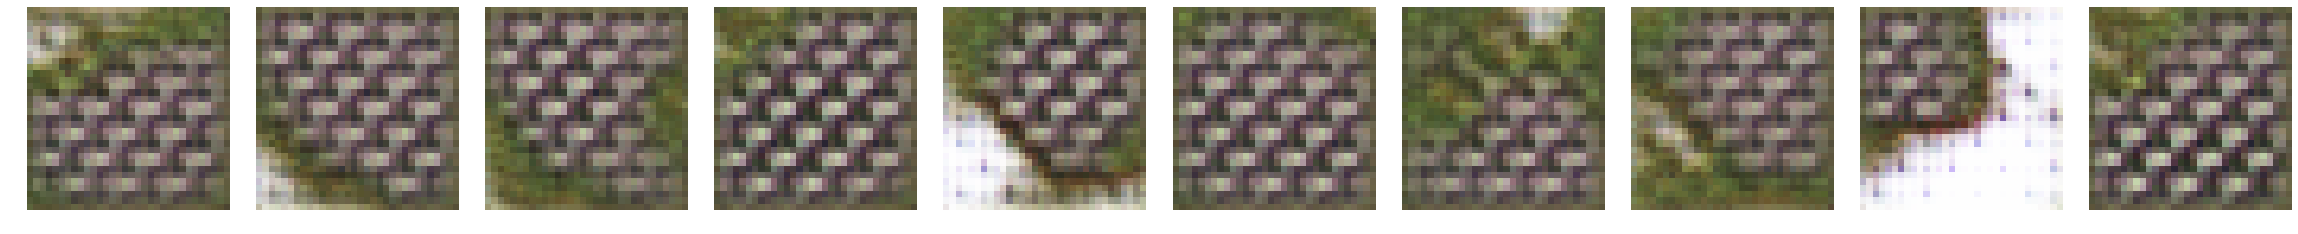

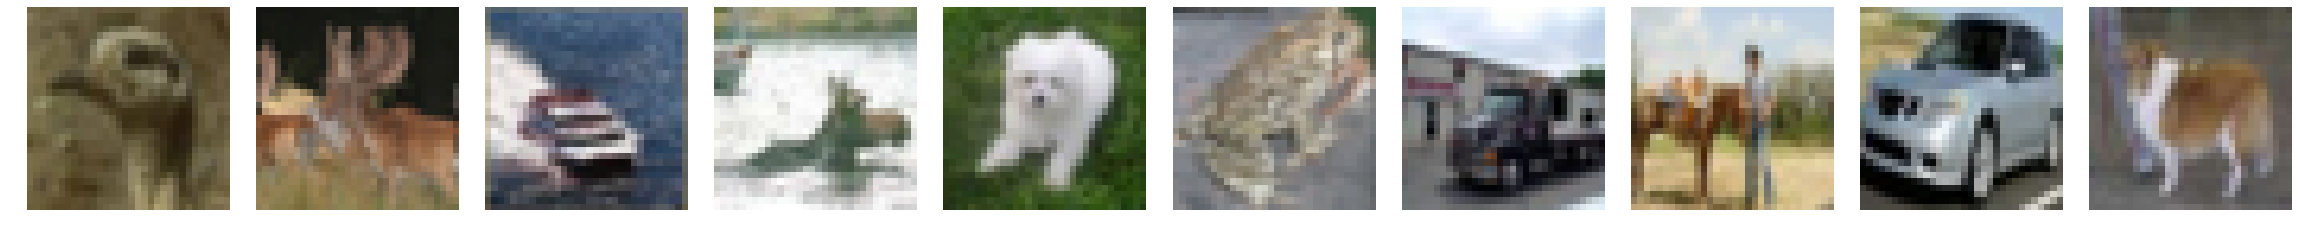

Starting Epoch (2201,100000), Time is 3.89, DLoss: 0.16717365384101868, DAcc:0.0, GLoss: 1.923988938331604, GAcc:0.0
Starting Epoch (2202,100000), Time is 0.55, DLoss: 0.15794411301612854, DAcc:0.0, GLoss: 1.66202974319458, GAcc:0.0
Starting Epoch (2203,100000), Time is 0.45, DLoss: 0.16845722496509552, DAcc:0.0, GLoss: 1.9425216913223267, GAcc:0.0
Starting Epoch (2204,100000), Time is 0.45, DLoss: 0.15688425302505493, DAcc:0.0, GLoss: 2.360053062438965, GAcc:0.0
Starting Epoch (2205,100000), Time is 0.44, DLoss: 0.1598266065120697, DAcc:0.0, GLoss: 2.4896745681762695, GAcc:0.0
Starting Epoch (2206,100000), Time is 0.46, DLoss: 0.14859402179718018, DAcc:0.0, GLoss: 2.3306639194488525, GAcc:0.0
Starting Epoch (2207,100000), Time is 0.44, DLoss: 0.15483492612838745, DAcc:0.0, GLoss: 1.9626693725585938, GAcc:0.0
Starting Epoch (2208,100000), Time is 0.44, DLoss: 0.14634719491004944, DAcc:0.0, GLoss: 2.1260807514190674, GAcc:0.0
Starting Epoch (2209,100000), Time is 0.45, DLoss: 0.15703277

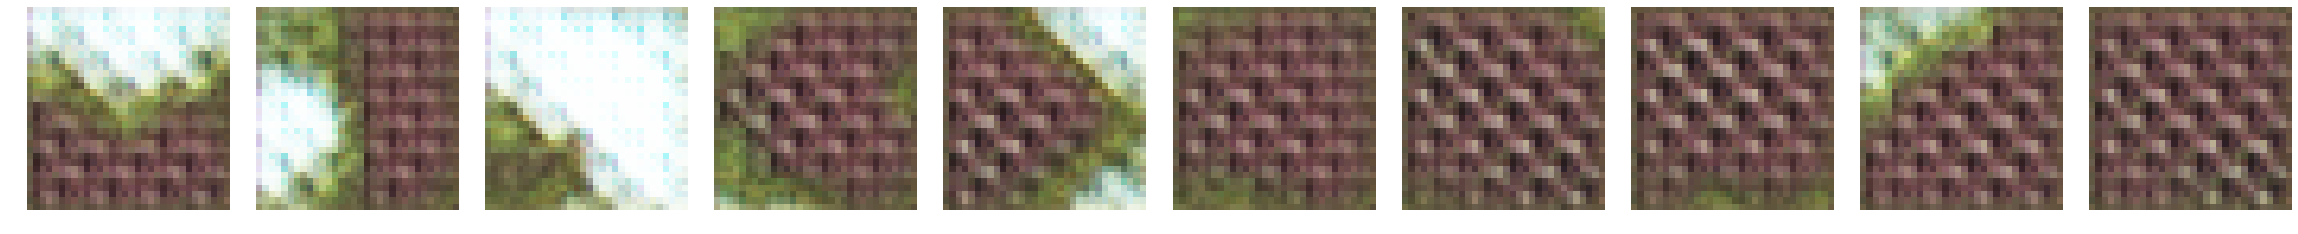

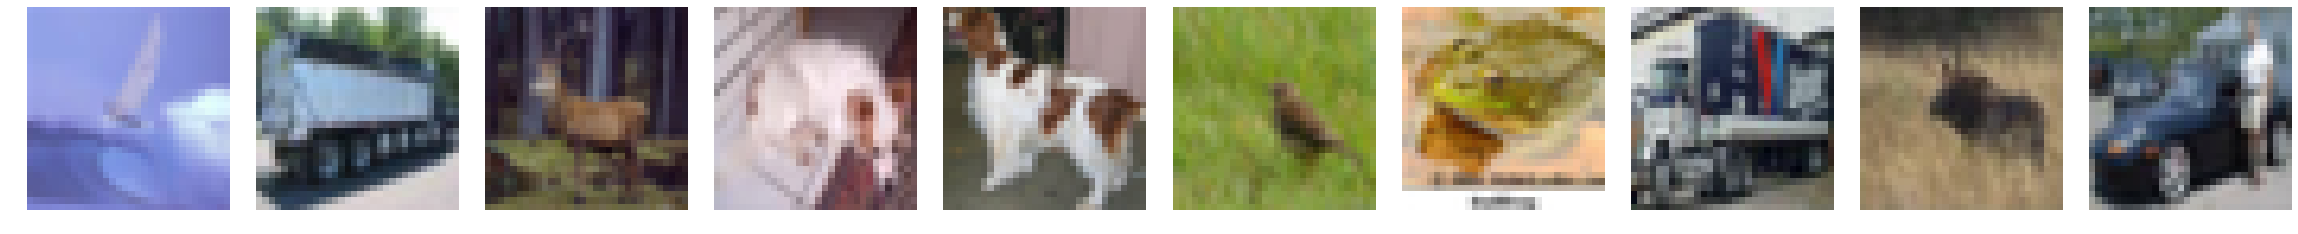

Starting Epoch (2301,100000), Time is 3.77, DLoss: 0.17582055926322937, DAcc:0.0, GLoss: 2.5492117404937744, GAcc:0.0
Starting Epoch (2302,100000), Time is 0.55, DLoss: 0.16445767879486084, DAcc:0.0, GLoss: 2.52852725982666, GAcc:0.0
Starting Epoch (2303,100000), Time is 0.46, DLoss: 0.1844540685415268, DAcc:0.0, GLoss: 2.171412706375122, GAcc:0.0
Starting Epoch (2304,100000), Time is 0.44, DLoss: 0.22170963883399963, DAcc:0.0, GLoss: 2.0672245025634766, GAcc:0.0
Starting Epoch (2305,100000), Time is 0.45, DLoss: 0.17654956877231598, DAcc:0.0, GLoss: 2.322996139526367, GAcc:0.0
Starting Epoch (2306,100000), Time is 0.44, DLoss: 0.15080897510051727, DAcc:0.0, GLoss: 2.692413330078125, GAcc:0.0
Starting Epoch (2307,100000), Time is 0.44, DLoss: 0.164255291223526, DAcc:0.0, GLoss: 2.3786191940307617, GAcc:0.0
Starting Epoch (2308,100000), Time is 0.43, DLoss: 0.15807771682739258, DAcc:0.0, GLoss: 1.9047054052352905, GAcc:0.0
Starting Epoch (2309,100000), Time is 0.44, DLoss: 0.16243654489

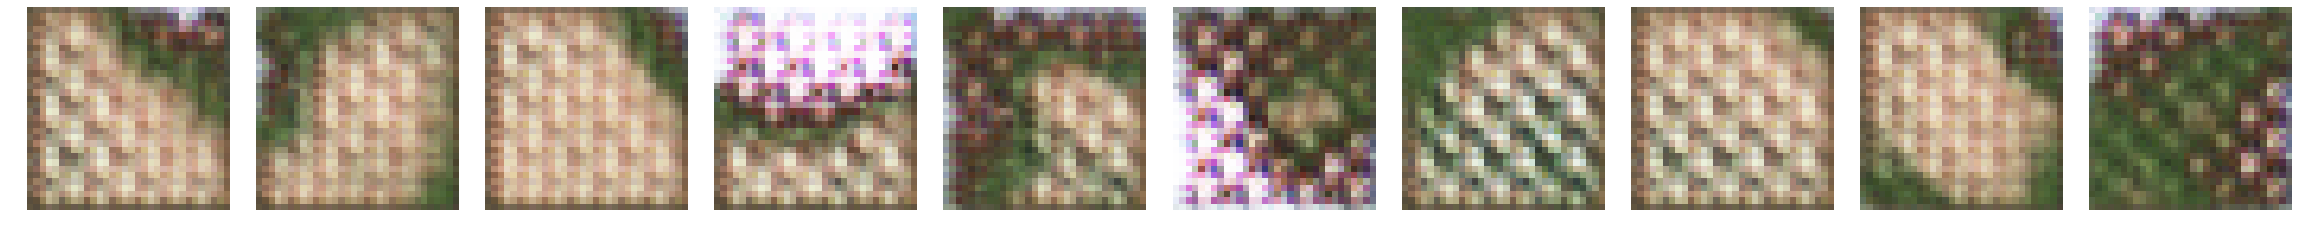

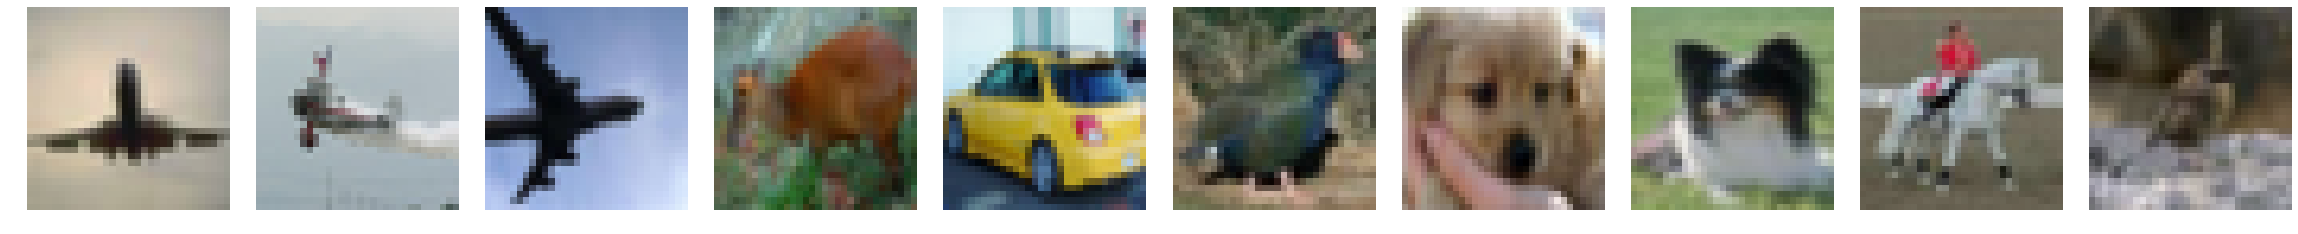

Starting Epoch (2401,100000), Time is 3.95, DLoss: 0.15888729691505432, DAcc:0.0, GLoss: 1.5144834518432617, GAcc:0.0
Starting Epoch (2402,100000), Time is 0.47, DLoss: 0.1551646590232849, DAcc:0.0, GLoss: 1.4108930826187134, GAcc:0.0
Starting Epoch (2403,100000), Time is 0.44, DLoss: 0.16357341408729553, DAcc:0.0, GLoss: 1.3753695487976074, GAcc:0.0
Starting Epoch (2404,100000), Time is 0.45, DLoss: 0.15181784331798553, DAcc:0.0, GLoss: 1.4068341255187988, GAcc:0.0
Starting Epoch (2405,100000), Time is 0.45, DLoss: 0.16358746588230133, DAcc:0.0, GLoss: 1.3891671895980835, GAcc:0.0
Starting Epoch (2406,100000), Time is 0.44, DLoss: 0.15376272797584534, DAcc:0.0, GLoss: 1.500812292098999, GAcc:0.0
Starting Epoch (2407,100000), Time is 0.46, DLoss: 0.1492479145526886, DAcc:0.0, GLoss: 1.7276861667633057, GAcc:0.0
Starting Epoch (2408,100000), Time is 0.44, DLoss: 0.1489822268486023, DAcc:0.0, GLoss: 1.693324327468872, GAcc:0.0
Starting Epoch (2409,100000), Time is 0.43, DLoss: 0.16567811

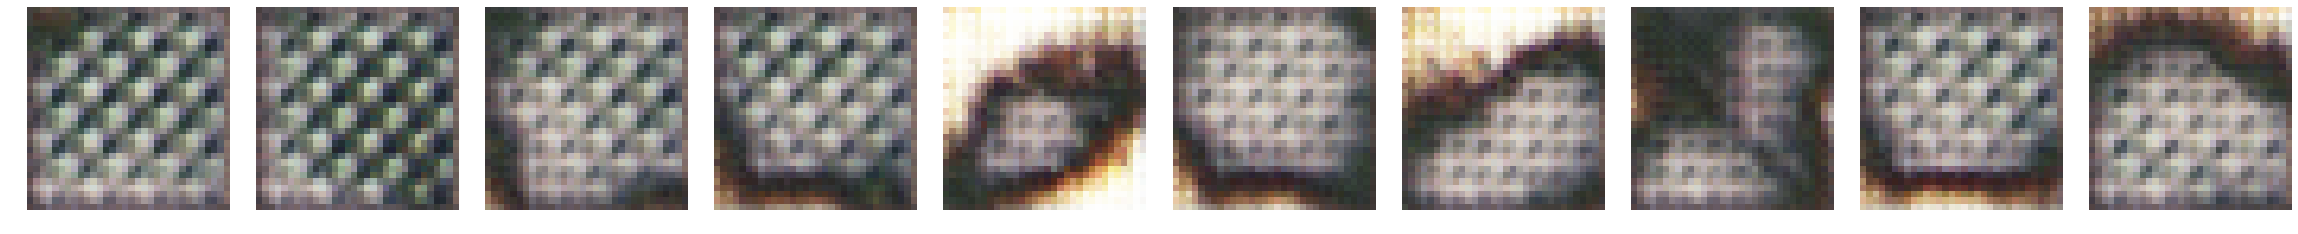

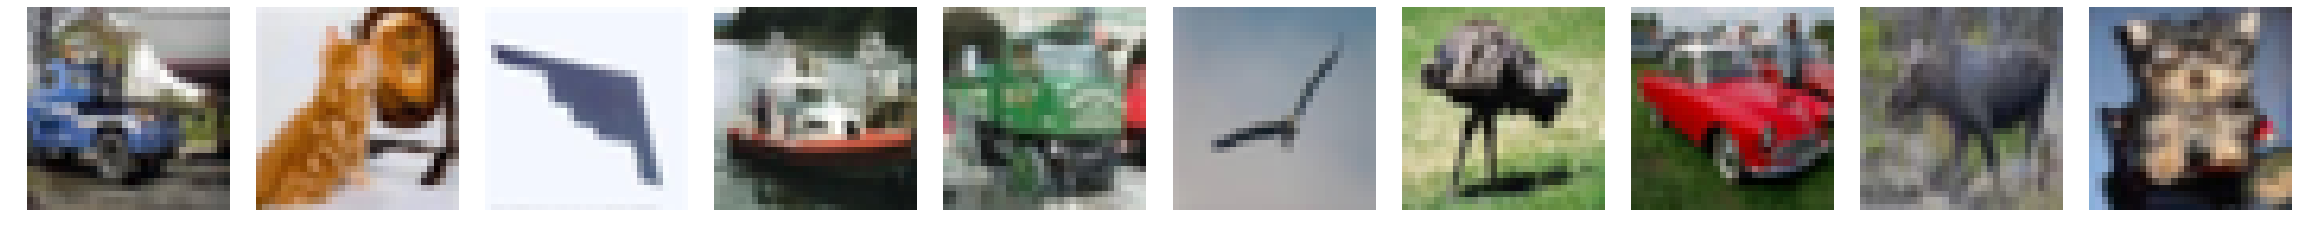

Starting Epoch (2501,100000), Time is 3.75, DLoss: 0.16938799619674683, DAcc:0.0, GLoss: 2.27514910697937, GAcc:0.0
Starting Epoch (2502,100000), Time is 0.48, DLoss: 0.20105703175067902, DAcc:0.0, GLoss: 1.7036030292510986, GAcc:0.0
Starting Epoch (2503,100000), Time is 0.44, DLoss: 0.1777905970811844, DAcc:0.0, GLoss: 2.071587562561035, GAcc:0.0
Starting Epoch (2504,100000), Time is 0.44, DLoss: 0.17175449430942535, DAcc:0.0, GLoss: 2.523301601409912, GAcc:0.0
Starting Epoch (2505,100000), Time is 0.44, DLoss: 0.18486887216567993, DAcc:0.0, GLoss: 2.1076414585113525, GAcc:0.0
Starting Epoch (2506,100000), Time is 0.44, DLoss: 0.14731252193450928, DAcc:0.0, GLoss: 2.0723769664764404, GAcc:0.0
Starting Epoch (2507,100000), Time is 0.44, DLoss: 0.17630600929260254, DAcc:0.0, GLoss: 2.0280253887176514, GAcc:0.0
Starting Epoch (2508,100000), Time is 0.44, DLoss: 0.19871480762958527, DAcc:0.0, GLoss: 1.8685212135314941, GAcc:0.0
Starting Epoch (2509,100000), Time is 0.45, DLoss: 0.15505686

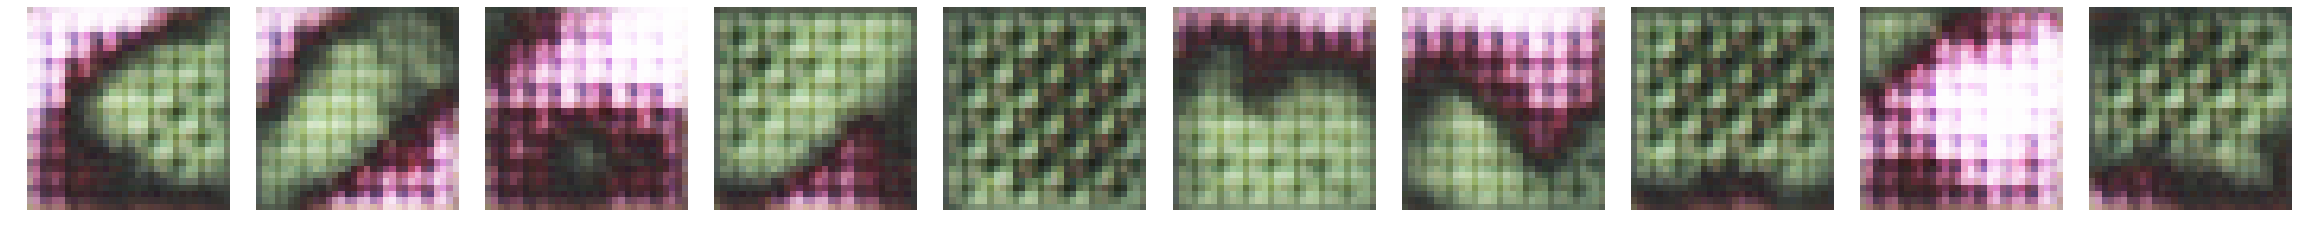

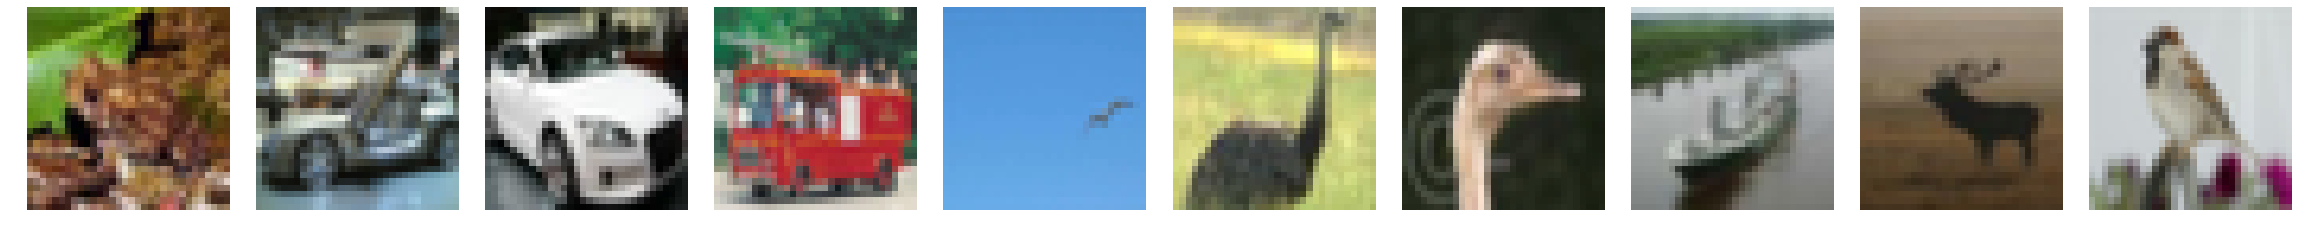

Starting Epoch (2601,100000), Time is 3.87, DLoss: 0.14930370450019836, DAcc:0.0, GLoss: 3.1167707443237305, GAcc:0.0
Starting Epoch (2602,100000), Time is 0.55, DLoss: 0.16381916403770447, DAcc:0.0, GLoss: 2.885561943054199, GAcc:0.0
Starting Epoch (2603,100000), Time is 0.46, DLoss: 0.14828217029571533, DAcc:0.0, GLoss: 3.5760936737060547, GAcc:0.0
Starting Epoch (2604,100000), Time is 0.44, DLoss: 0.14584121108055115, DAcc:0.0, GLoss: 3.648740530014038, GAcc:0.0
Starting Epoch (2605,100000), Time is 0.44, DLoss: 0.1760140359401703, DAcc:0.0, GLoss: 2.6202645301818848, GAcc:0.0
Starting Epoch (2606,100000), Time is 0.44, DLoss: 0.15550874173641205, DAcc:0.0, GLoss: 2.426178455352783, GAcc:0.0
Starting Epoch (2607,100000), Time is 0.44, DLoss: 0.15605191886425018, DAcc:0.0, GLoss: 2.8757166862487793, GAcc:0.0
Starting Epoch (2608,100000), Time is 0.44, DLoss: 0.1563941091299057, DAcc:0.0, GLoss: 2.663405418395996, GAcc:0.0
Starting Epoch (2609,100000), Time is 0.44, DLoss: 0.168308943

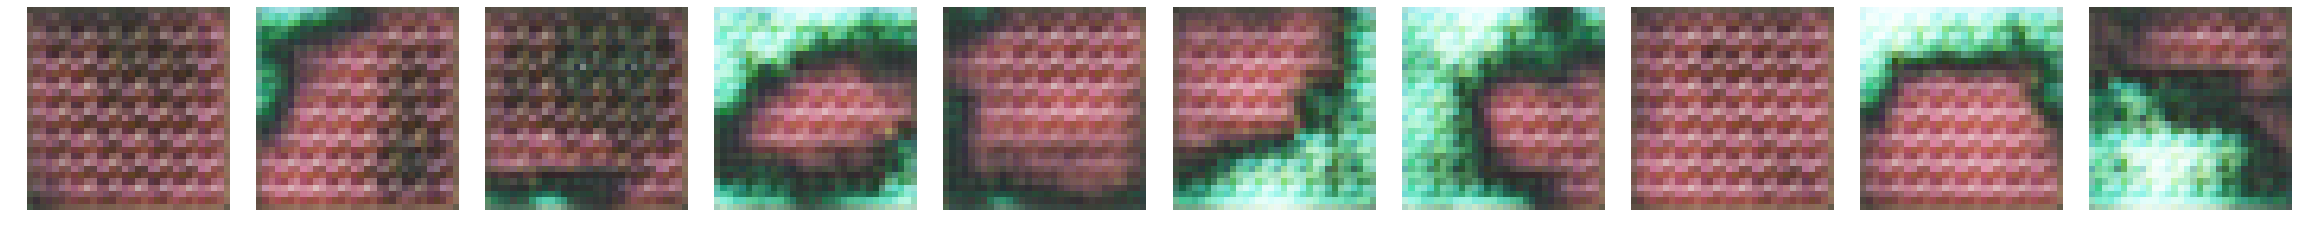

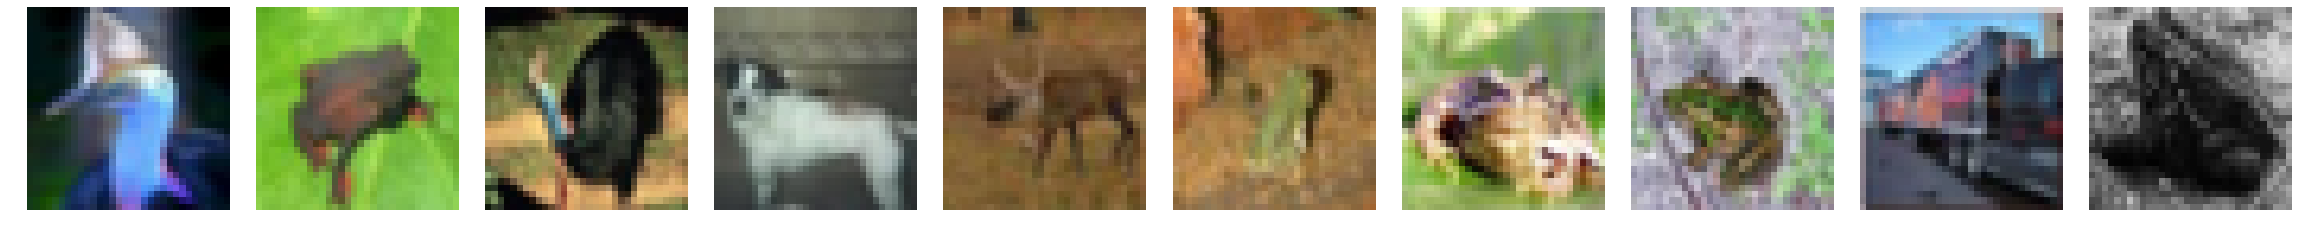

Starting Epoch (2701,100000), Time is 3.79, DLoss: 0.14509958028793335, DAcc:0.0, GLoss: 2.587080478668213, GAcc:0.0
Starting Epoch (2702,100000), Time is 0.55, DLoss: 0.1480845957994461, DAcc:0.0, GLoss: 2.637117862701416, GAcc:0.0
Starting Epoch (2703,100000), Time is 0.45, DLoss: 0.15951748192310333, DAcc:0.0, GLoss: 2.23514461517334, GAcc:0.0
Starting Epoch (2704,100000), Time is 0.44, DLoss: 0.1488923728466034, DAcc:0.0, GLoss: 2.1827244758605957, GAcc:0.0
Starting Epoch (2705,100000), Time is 0.44, DLoss: 0.149061918258667, DAcc:0.0, GLoss: 2.259876251220703, GAcc:0.0
Starting Epoch (2706,100000), Time is 0.43, DLoss: 0.15632572770118713, DAcc:0.0, GLoss: 2.3539986610412598, GAcc:0.0
Starting Epoch (2707,100000), Time is 0.44, DLoss: 0.15123414993286133, DAcc:0.0, GLoss: 2.5397753715515137, GAcc:0.0
Starting Epoch (2708,100000), Time is 0.44, DLoss: 0.14437581598758698, DAcc:0.0, GLoss: 2.4677090644836426, GAcc:0.0
Starting Epoch (2709,100000), Time is 0.44, DLoss: 0.163101226091

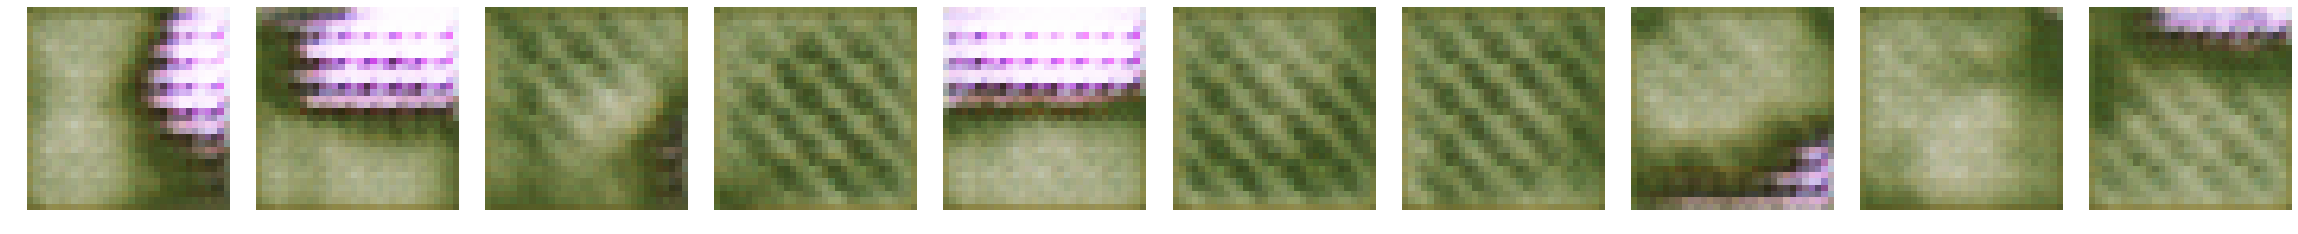

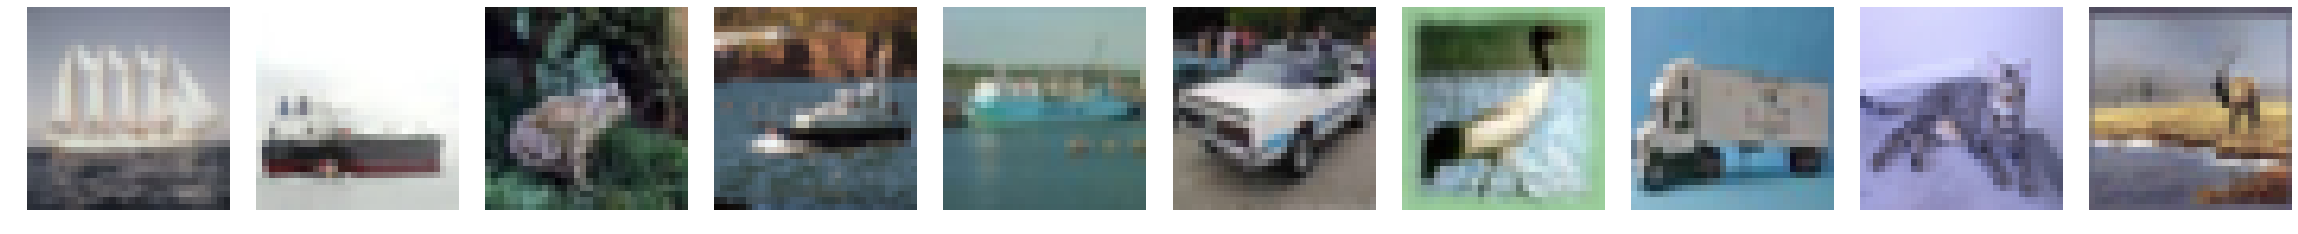

Starting Epoch (2801,100000), Time is 3.91, DLoss: 0.1707744598388672, DAcc:0.0, GLoss: 2.8230323791503906, GAcc:0.0
Starting Epoch (2802,100000), Time is 0.54, DLoss: 0.16450265049934387, DAcc:0.0, GLoss: 2.670213222503662, GAcc:0.0
Starting Epoch (2803,100000), Time is 0.45, DLoss: 0.1700480580329895, DAcc:0.0, GLoss: 2.322028160095215, GAcc:0.0
Starting Epoch (2804,100000), Time is 0.44, DLoss: 0.18361738324165344, DAcc:0.0, GLoss: 1.816214680671692, GAcc:0.0
Starting Epoch (2805,100000), Time is 0.44, DLoss: 0.17664077877998352, DAcc:0.0, GLoss: 1.938992977142334, GAcc:0.0
Starting Epoch (2806,100000), Time is 0.44, DLoss: 0.18129923939704895, DAcc:0.0, GLoss: 2.2147464752197266, GAcc:0.0
Starting Epoch (2807,100000), Time is 0.44, DLoss: 0.18132704496383667, DAcc:0.0, GLoss: 2.7422616481781006, GAcc:0.0
Starting Epoch (2808,100000), Time is 0.44, DLoss: 0.14690887928009033, DAcc:0.0, GLoss: 2.841705322265625, GAcc:0.0
Starting Epoch (2809,100000), Time is 0.44, DLoss: 0.2044419348

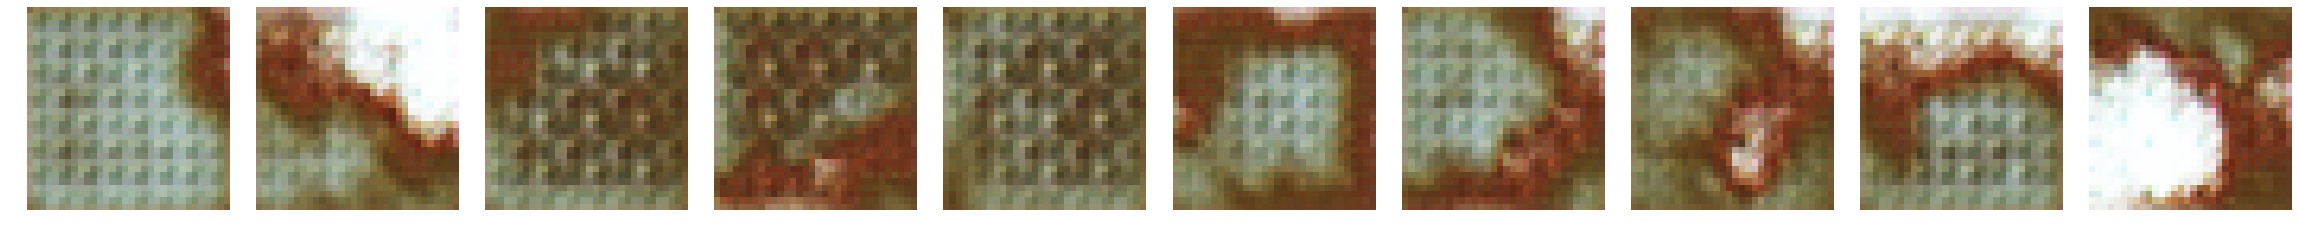

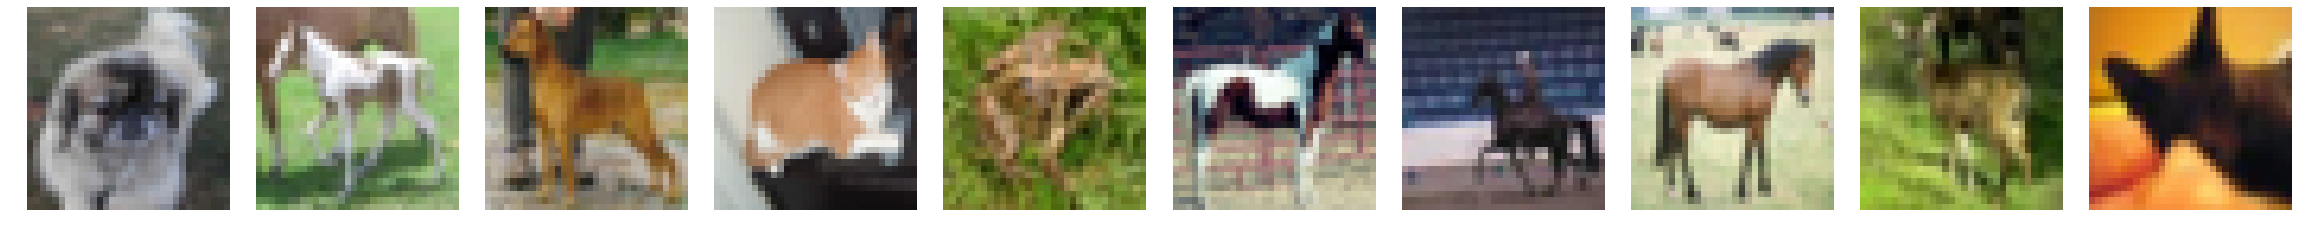

Starting Epoch (2901,100000), Time is 3.74, DLoss: 0.15603387355804443, DAcc:0.0, GLoss: 2.2314131259918213, GAcc:0.0
Starting Epoch (2902,100000), Time is 0.53, DLoss: 0.16691040992736816, DAcc:0.0, GLoss: 2.223219871520996, GAcc:0.0
Starting Epoch (2903,100000), Time is 0.45, DLoss: 0.15371206402778625, DAcc:0.0, GLoss: 2.2810301780700684, GAcc:0.0
Starting Epoch (2904,100000), Time is 0.44, DLoss: 0.15367671847343445, DAcc:0.0, GLoss: 2.337763786315918, GAcc:0.0
Starting Epoch (2905,100000), Time is 0.44, DLoss: 0.1619264781475067, DAcc:0.0, GLoss: 2.286555528640747, GAcc:0.0
Starting Epoch (2906,100000), Time is 0.44, DLoss: 0.15023380517959595, DAcc:0.0, GLoss: 2.4046459197998047, GAcc:0.0
Starting Epoch (2907,100000), Time is 0.46, DLoss: 0.17947575449943542, DAcc:0.0, GLoss: 2.271312713623047, GAcc:0.0
Starting Epoch (2908,100000), Time is 0.45, DLoss: 0.1674950122833252, DAcc:0.0, GLoss: 2.297206163406372, GAcc:0.0
Starting Epoch (2909,100000), Time is 0.45, DLoss: 0.1628646701

In [0]:
train(100000, 128)

show_images('real', 5)
show_images('fake', 5)